In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
sys.path.append("../")
import matplotlib.pyplot as plt
import time

In [2]:
import preprocess_blockSVD as pre_svd
import trefide as tfd
import spatial_filtering as sp_filters
#from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
#import scipy as sp
import tools as tools
import cvxpy as cp
import caiman as cm


/home/ekellbuch/miniconda2/envs/volcaim/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import h5py

project_dir = '/data/lab/Dropbox/QState_IntrinsicExcitability/'
fname = 'IntrinsicExcitability_movie017.mat'
#data = sio.loadmat(project_dir+fname)
with h5py.File(os.path.join(project_dir, fname)) as f:
    m_orig = f['mov']['data'].value.T
    sampleRate = f['mov']['sampleRate'].value
    sampleRate_units = f['mov']['sampleRate_units'].value
    print(list(f['mov'].keys()))

['data', 'disclaimer', 'drug', 'fileNameHash', 'group', 'pixelSize', 'pixelSize_units', 'sampleRate', 'sampleRate_units', 'stimulation', 'timeDim']


(80, 800, 7082)
(900, 70, 70)


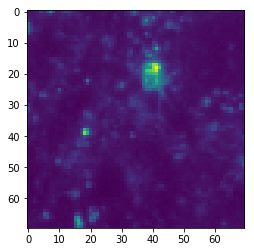

In [4]:
print(m_orig.shape)
m_orig_ = m_orig[5:-5,150:220,2100:3000].transpose([2,0,1])
print(m_orig_.shape)
plt.imshow(m_orig_[0,:,:])

In [5]:
def remove_trend(Y_rm,detrend_option='linear'):
    mean_pixel = Y_rm.mean(axis=1,keepdims=True)
    Y_rm2 = Y_rm - mean_pixel
    # Detrend linear 
    if detrend_option=='linear':
        detr_data = sp.signal.detrend(Y_rm2[:,:],axis=1,type='l')
    elif detrend_option=='quad':
        detr_data = detrend(Y_rm)
    Y_det = detr_data + mean_pixel
    offset = Y_rm - Y_det
    return Y_det, offset

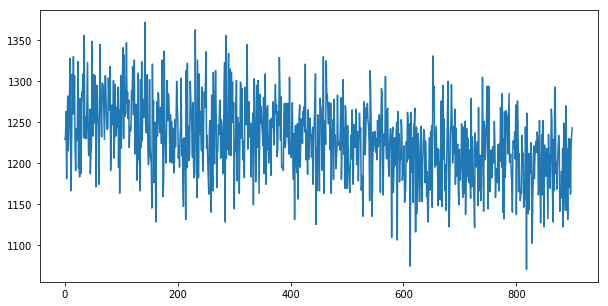

In [6]:
fig = plt.figure(figsize=(10,5))
plt.plot(m_orig_[:,0,0])

In [ ]:
Frame = cm.movie(m_orig_)#[100:5100,1:-5,28:]
Frame.play(gain=5, fr=10, magnification=5)

In [7]:
images_ = m_orig_.transpose([1,2,0])
dims = images_.shape
print(dims)

(70, 70, 900)


In [8]:
# Caserati representation d x T
images_r = images_.reshape((np.prod(dims[:2]),dims[2]),order='F')

# if temporal downsampling
if False:
    ts = 5
    images_r = pre_svd.temporal_decimation(images_r.T,ts).T
    dims = dims[0], dims[1], dims[2]//ts
# get rid of trend
if True:
    images_detr, offset = tools.remove_trend(images_r)
    images_r = images_detr.copy()
else:
    offset = np.zeros(images_r.shape)

In [9]:
#(0) 
if True:
    # run WF on Y
    images_wf,_ = sp_filters.spatial_filter_image(images_r.reshape(dims,order='F'))
    # cm.movie(images_wf).transpose([2,0,1]).play(magnification=10)
    images_wf = images_wf.reshape((np.prod(dims[:2]),dims[2]),order='F')
else:
    images_wf = images_r.copy()

first k pixels 0
first k pixels 1000
first k pixels 2000
first k pixels 3000
first k pixels 4000


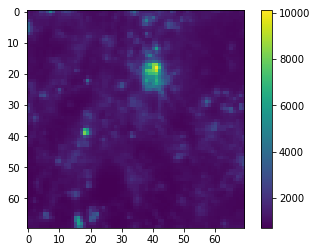

In [10]:
plt.imshow(images_wf.reshape(dims,order='F')[:,:,0])
plt.colorbar()

In [11]:
# subtract off the mean,
mean_px = images_wf.mean(1,keepdims=True)
images_wf = images_wf - mean_px
if True:
    # compute noise level
    # and normalize each pixel to have unit noise level
    noise_level = sp_filters.noise_estimator(images_wf[:,:],range_ff=[0.25,0.5])
    image_= images_wf/noise_level[:,np.newaxis]
    # confirm noise variance =1 in each pixel
    tmp_ = sp_filters.noise_estimator(image_[:,:],range_ff=[0.25,0.5])
    print(tmp_.min())
    print(tmp_.max())
else:
    image_ = images_wf

0.9999999999999984
1.0000000000000013


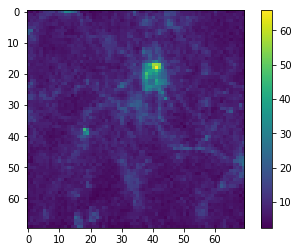

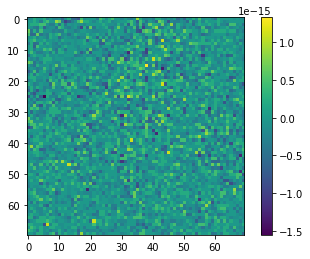

In [12]:
plt.imshow(noise_level.reshape(dims[:2],order='F'))
plt.colorbar()
plt.show()
plt.imshow(tmp_.reshape(dims[:2],order='F')-1)
plt.colorbar()

In [13]:
if False: # 1p, WF data
    U,s,Vt = pre_svd.compute_svd(image_,method='randomized',n_components=2)
    movie_rank2 = U.dot(np.diag(s).dot(Vt))
    residual = image_ - movie_rank2
    W = residual.reshape(dims,order='F')
else:
    W = image_.reshape(dims,order='F')

In [14]:
k = 25

Patch 0
	Patch 0 run for 0
Patch 1
	Patch 1 run for 0
Patch 2
	Patch 2 run for 0
Patch 3
	Patch 3 run for 0
Patch 4
	Patch 4 run for 0
Patch 5
	Patch 5 run for 0
Patch 6
	Patch 6 run for 0
Patch 7
	Patch 7 run for 0
Patch 8
	Patch 8 run for 0
Patch 9
	Patch 9 run for 0
Patch 10
	Patch 10 run for 0
Patch 11
	Patch 11 run for 0
Patch 12
	Patch 12 run for 0
Patch 13
	Patch 13 run for 0
Patch 14
	Patch 14 run for 0
Patch 15
	Patch 15 run for 0
Patch 16
	Patch 16 run for 0
Patch 17
	Patch 17 run for 0
Patch 18
	Patch 18 run for 0
Patch 19
	Patch 19 run for 0
Patch 20
	Patch 20 run for 0
Patch 21
Forcing one component
	Patch 21 run for 0
Patch 22
	Patch 22 run for 0
Patch 23
	Patch 23 run for 0
Patch 24
	Patch 24 run for 0


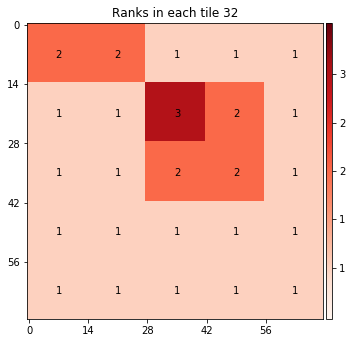

M rank 32


In [15]:
maxlag = 5#5
confidence = 0.95
min_rank = 1
Yd1,_ = pre_svd.svd_patch(W,k=k,maxlag=maxlag,confidence=confidence,
                                greedy=False,fudge_factor=1,
                                 mean_th_factor=2.,min_rank=min_rank)

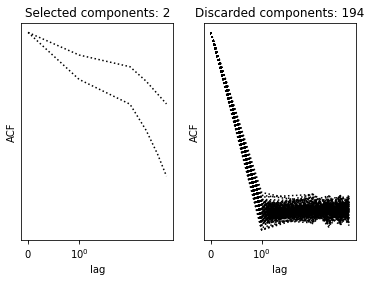

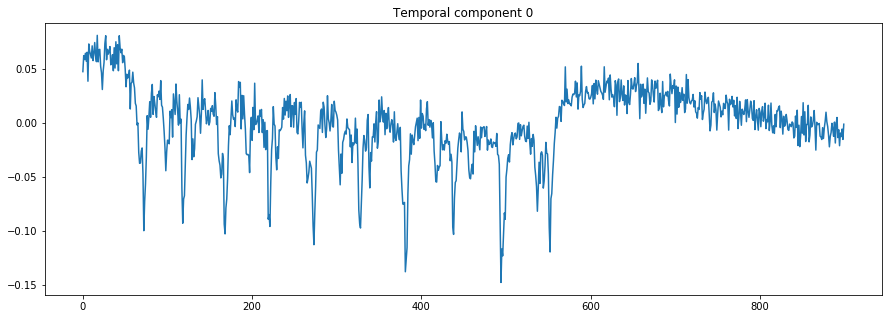

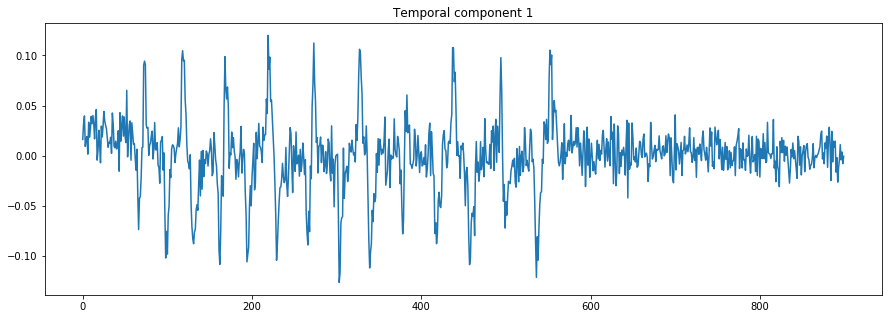

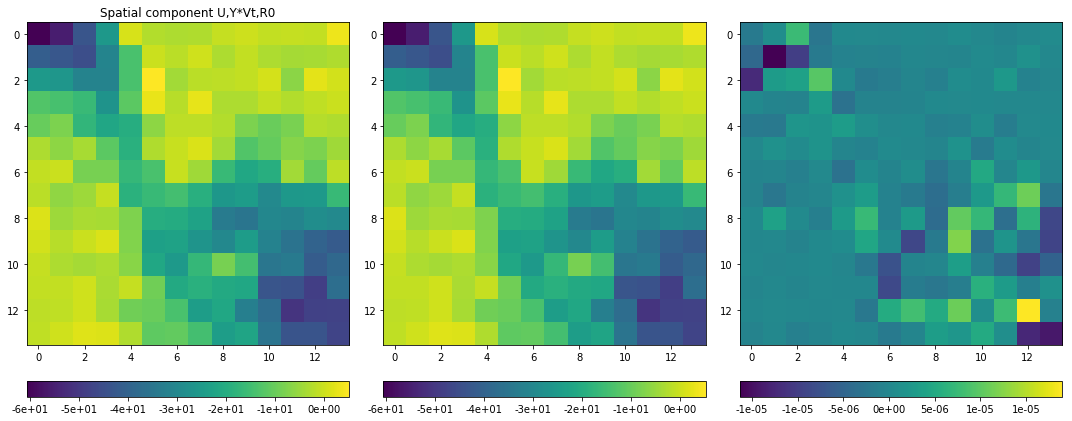

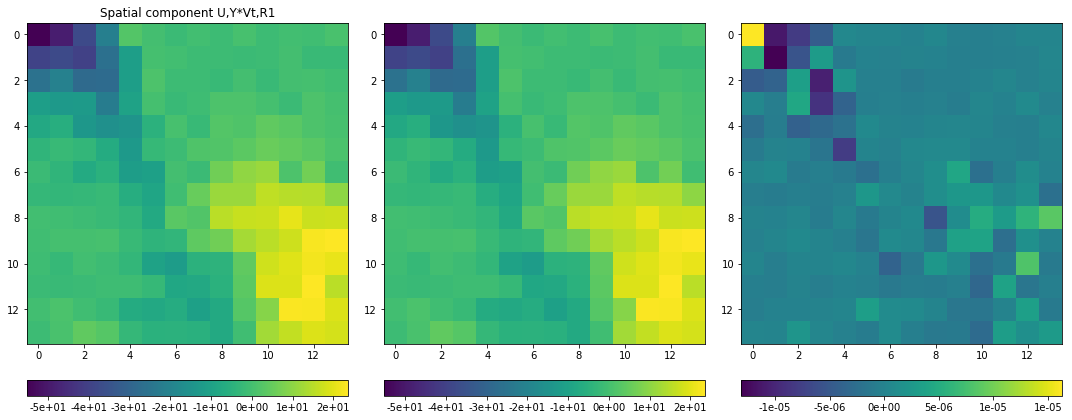

*Running Part (1) iter 0 with 2 components
solve V(i) = argmin_W ||D^2 W||_1 
	 st ||V_i-W||_2<fudge_factor*sigma_i*sqrt(T)


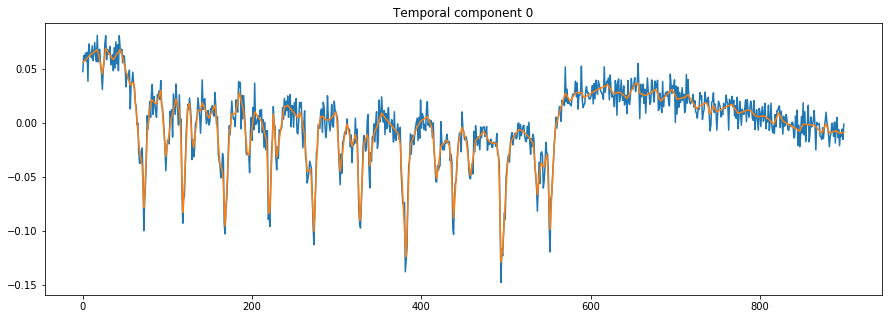

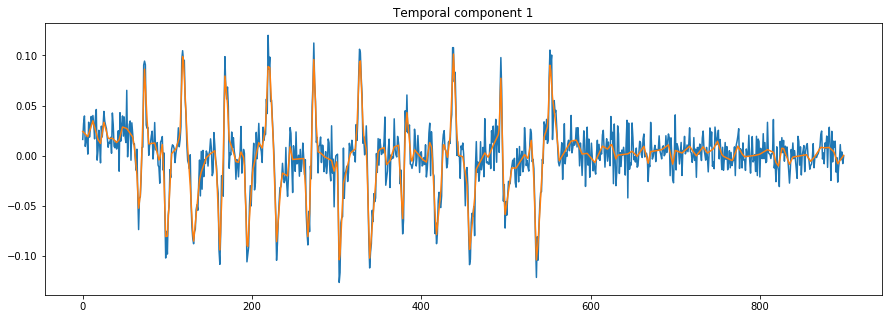

solve U(j) = argmin_W ||W||_1 st ||Y_j-W'V_TF(j)||_2^2<T*fudge^2


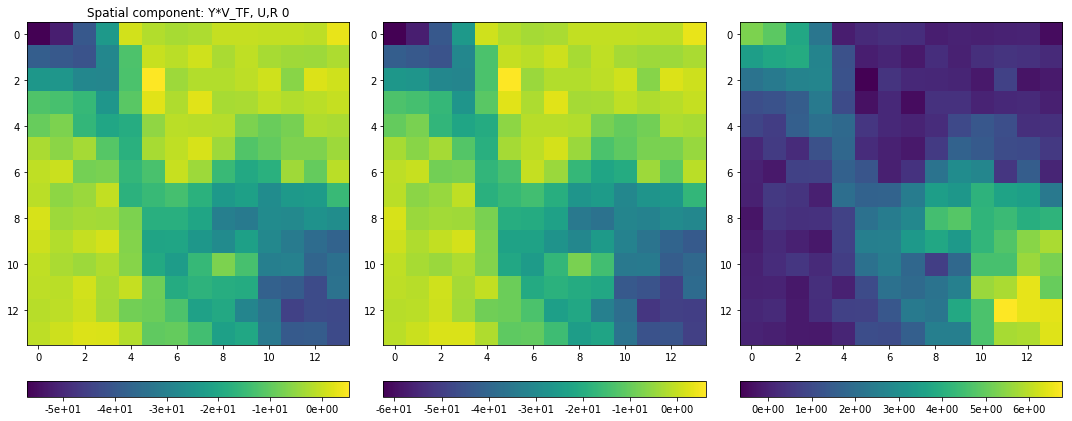

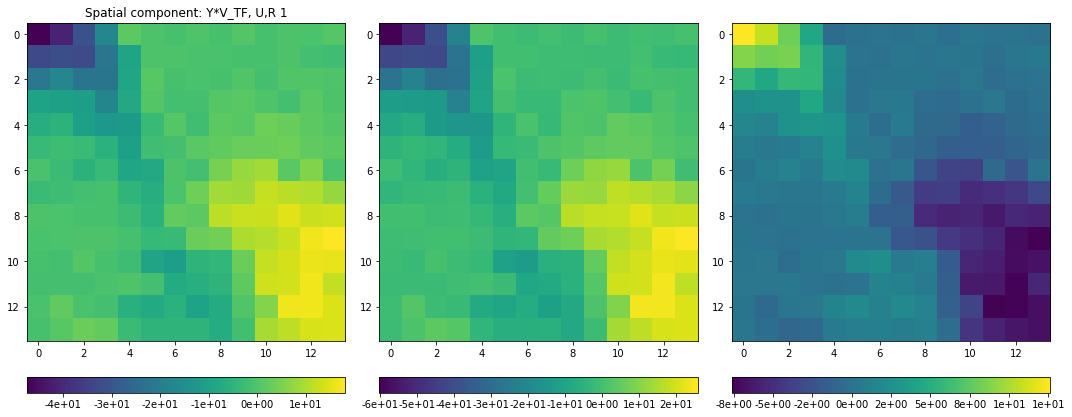

Iterate until F(U,V) stops decreasing significantly (relative convergence criterion)
max iterations set as 20
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


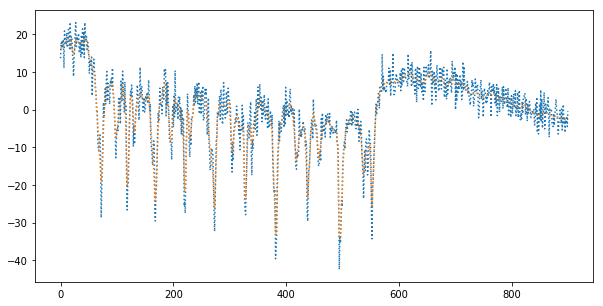

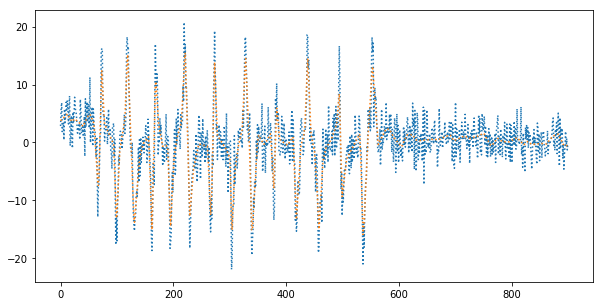

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


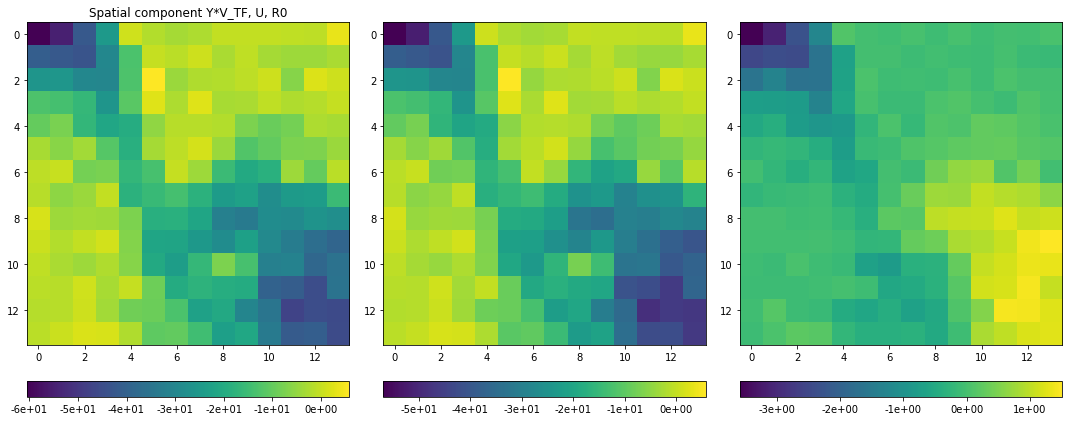

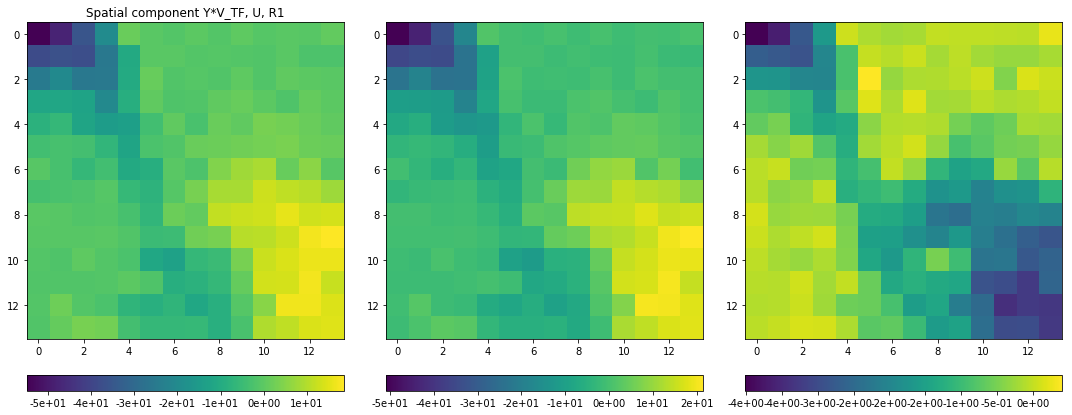

	Iter 0 errors (9024+41+0)=9066
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


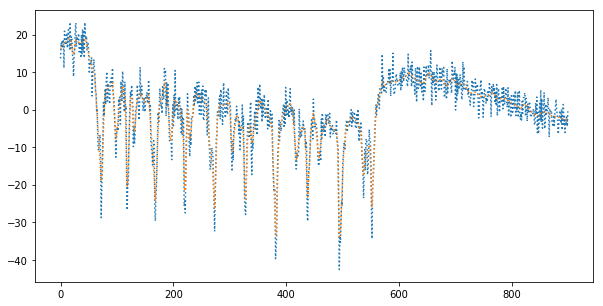

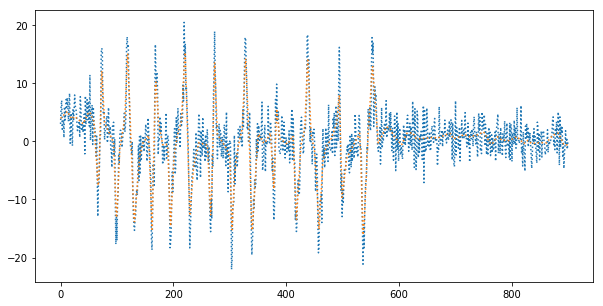

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


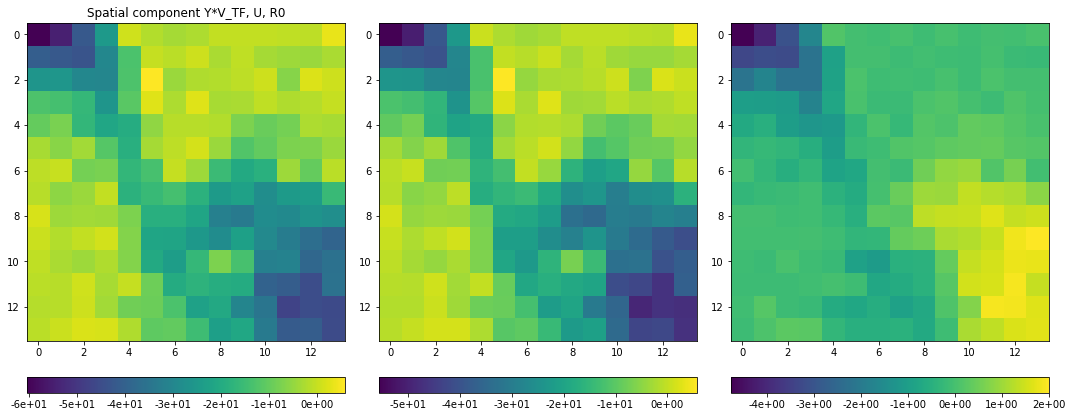

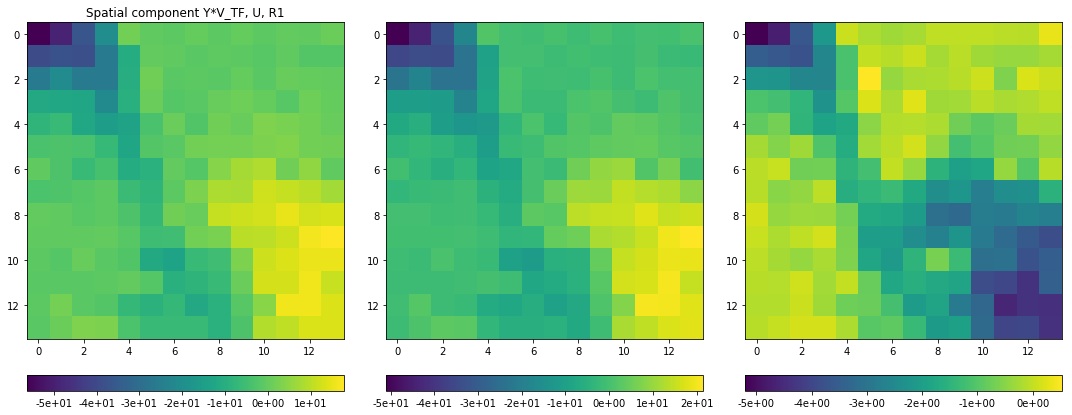

	Iter 1 errors (8994+41+0)=9035
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


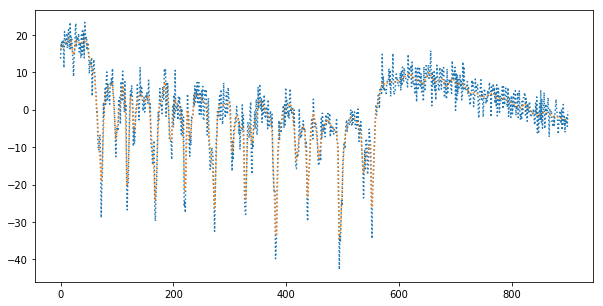

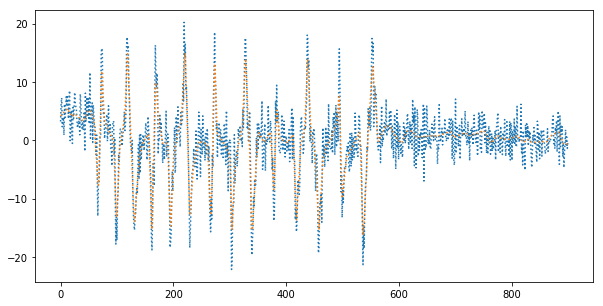

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


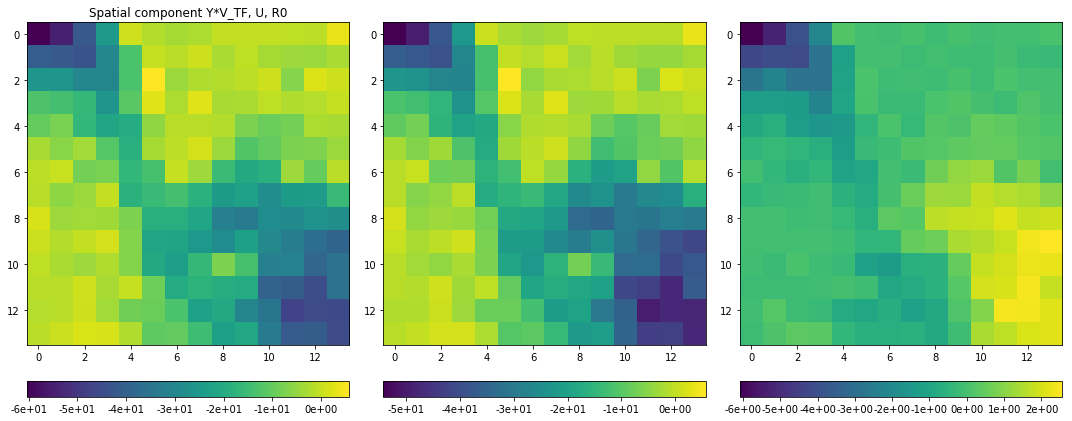

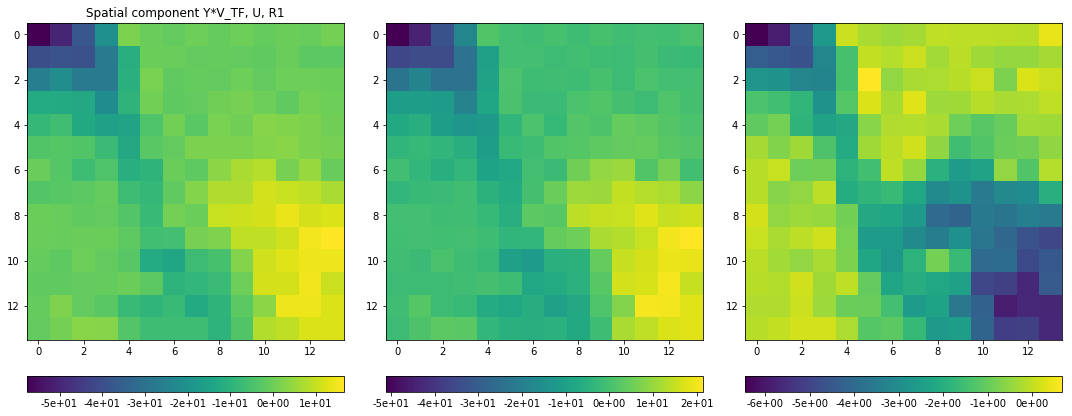

	Iter 2 errors (8968+41+0)=9009
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


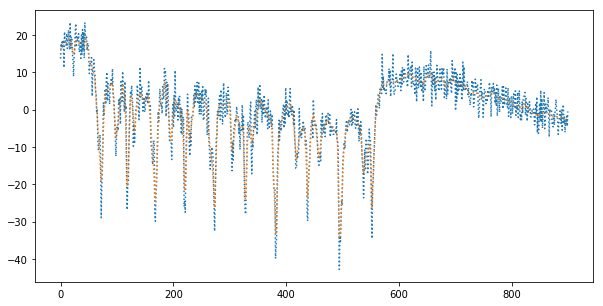

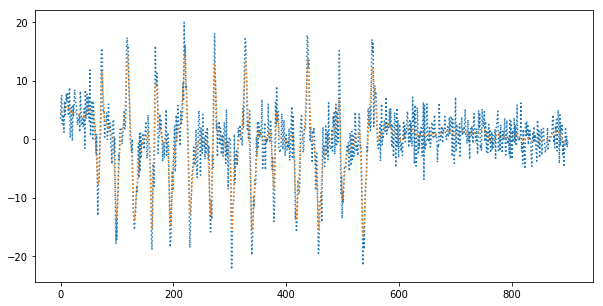

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


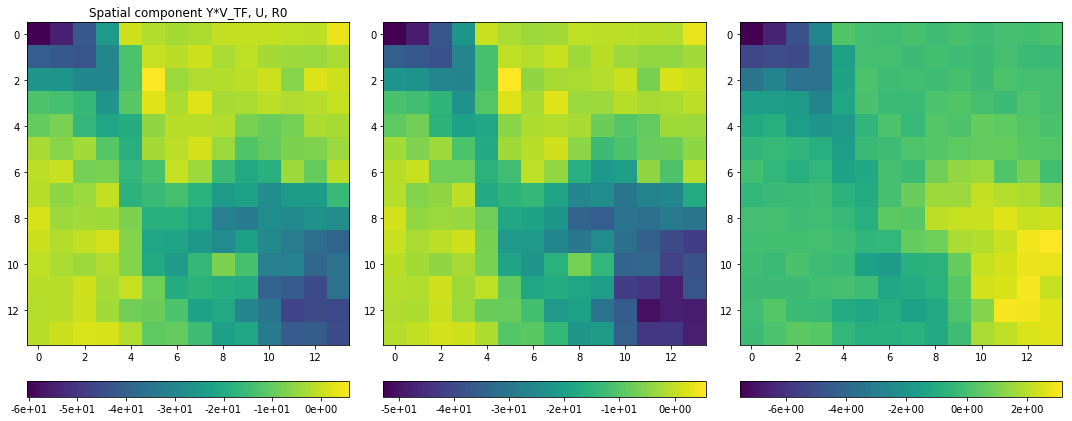

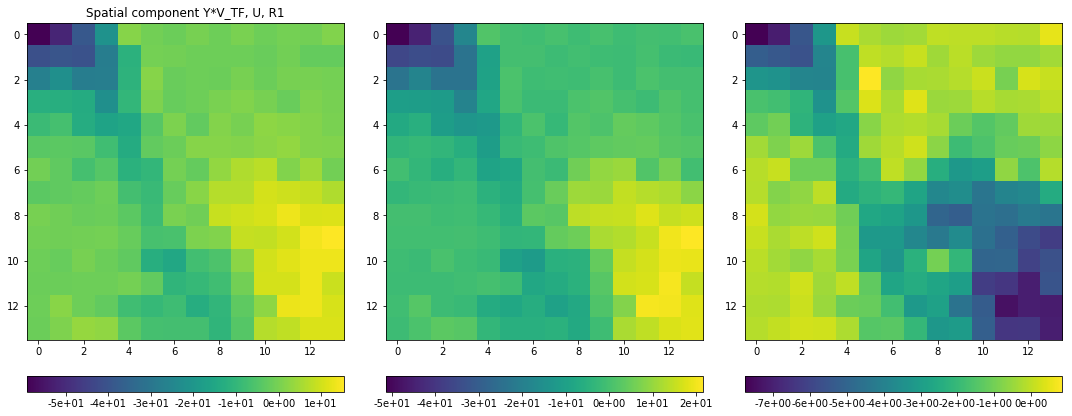

	Iter 3 errors (8940+40+0)=8980
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


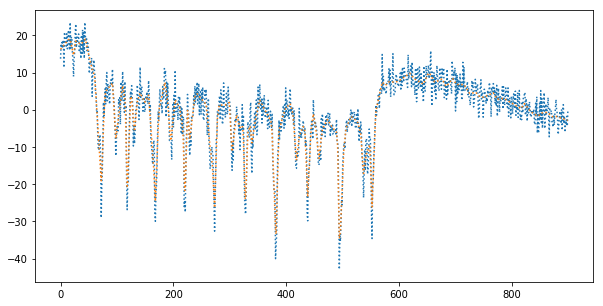

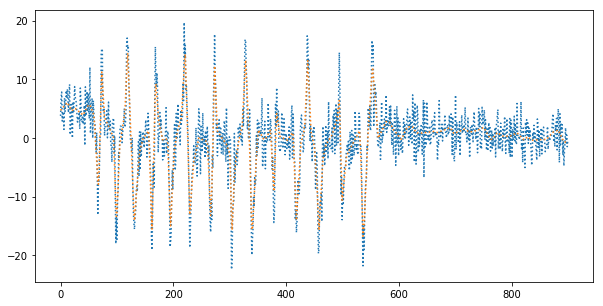

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


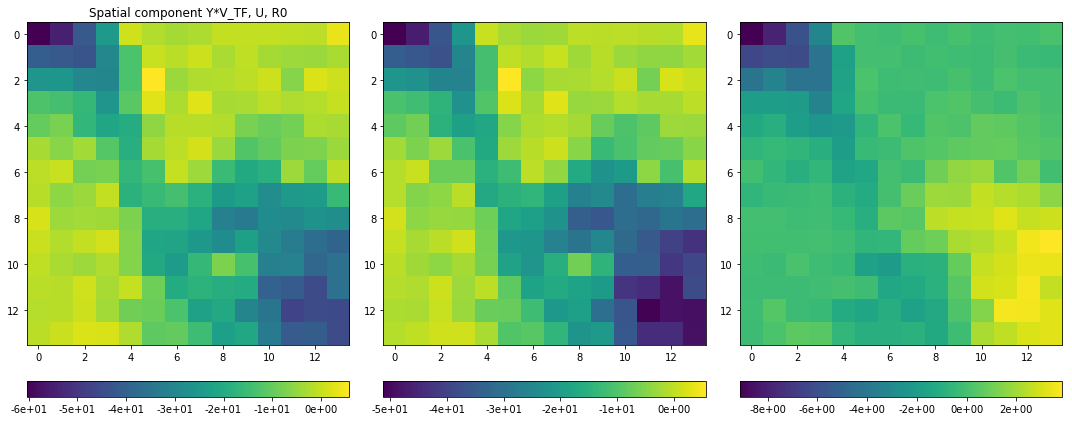

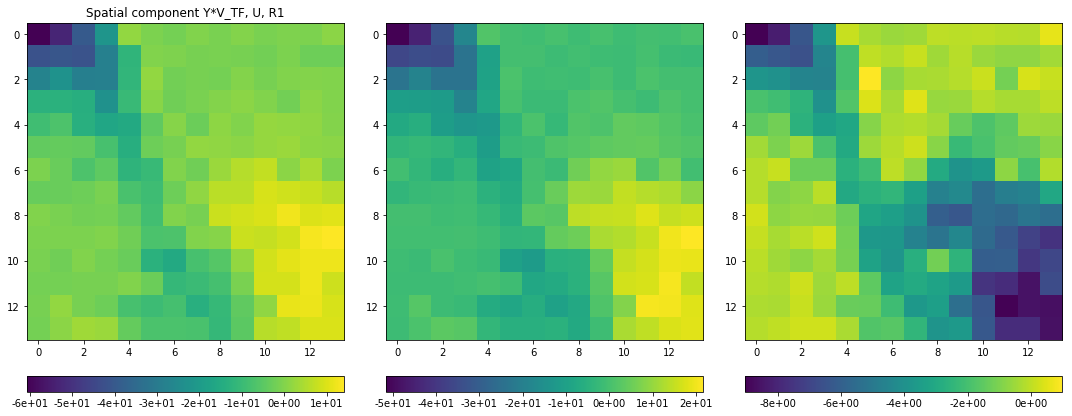

	Iter 4 errors (8910+40+0)=8950
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


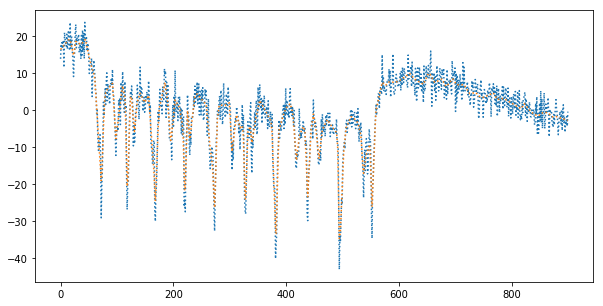

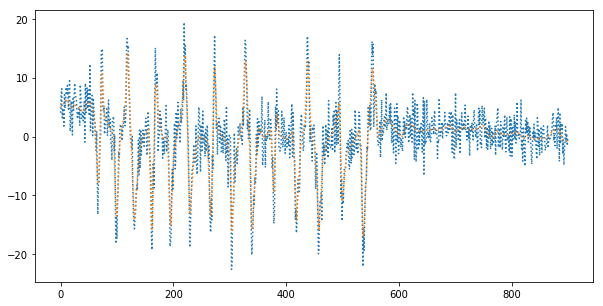

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


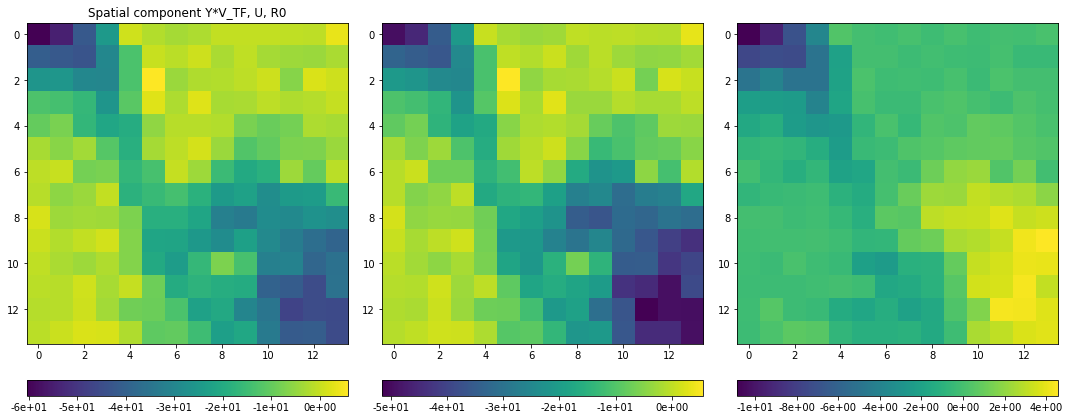

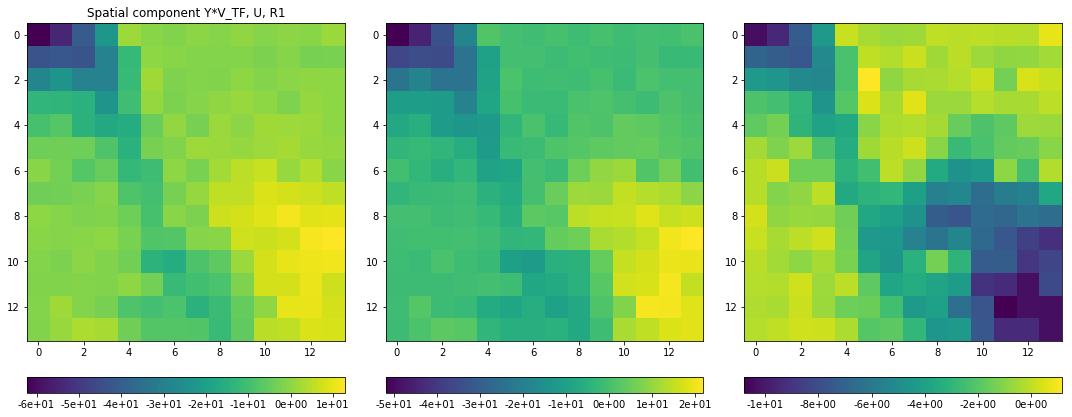

	Iter 5 errors (8878+40+0)=8918
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


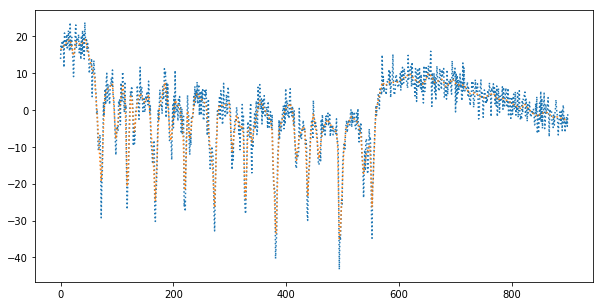

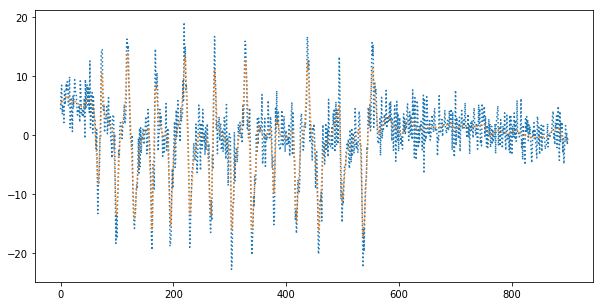

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


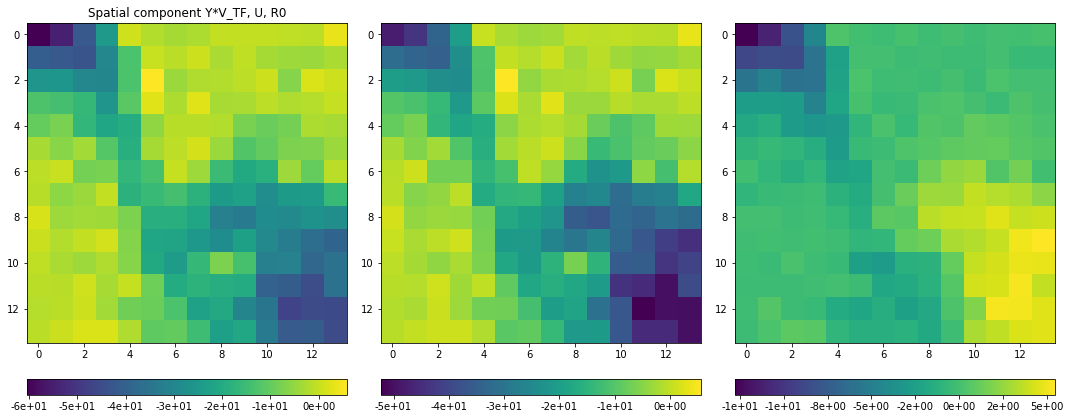

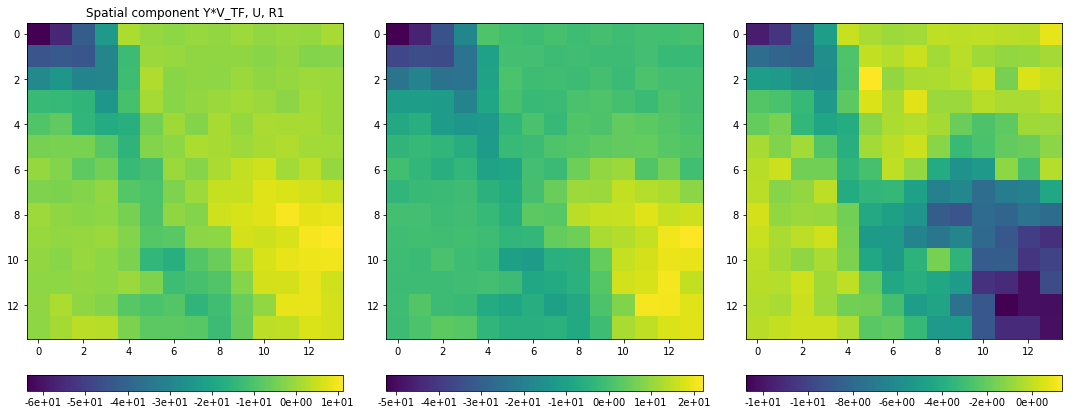

	Iter 6 errors (8844+40+0)=8884
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


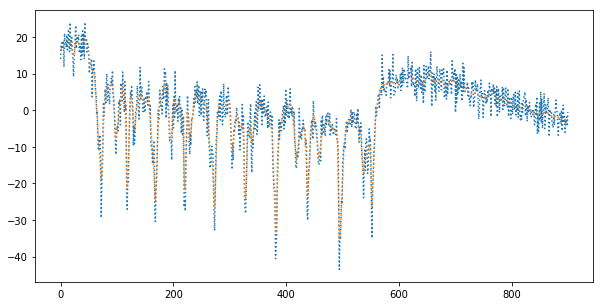

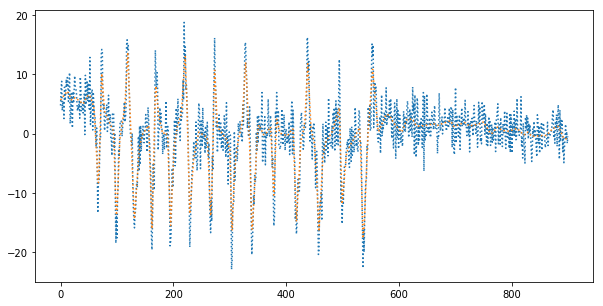

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


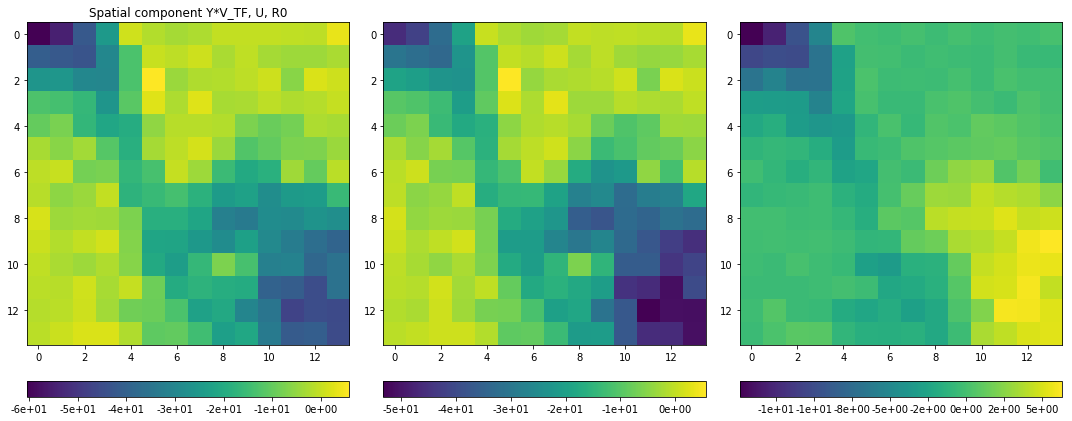

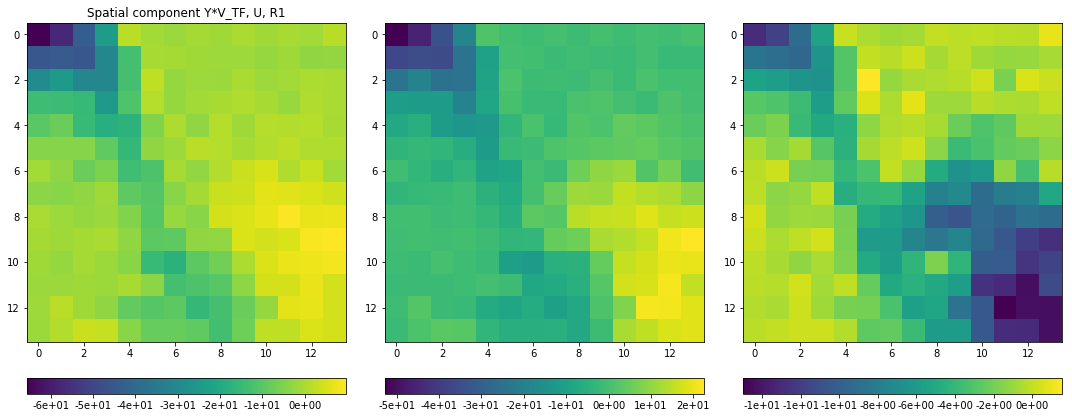

	Iter 7 errors (8807+39+0)=8846
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


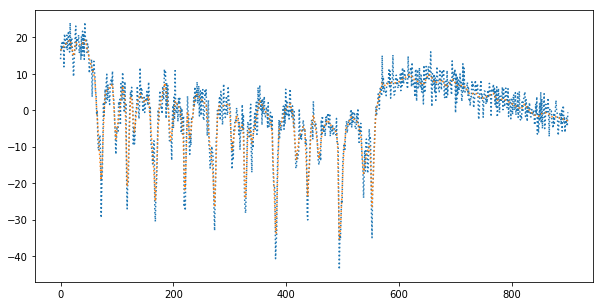

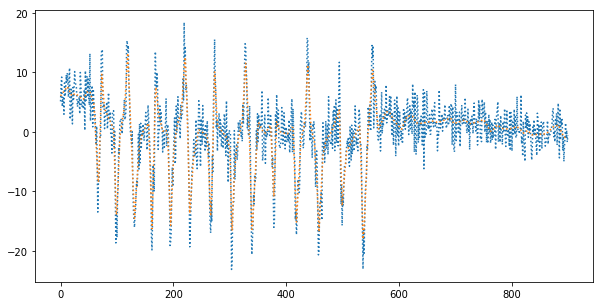

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


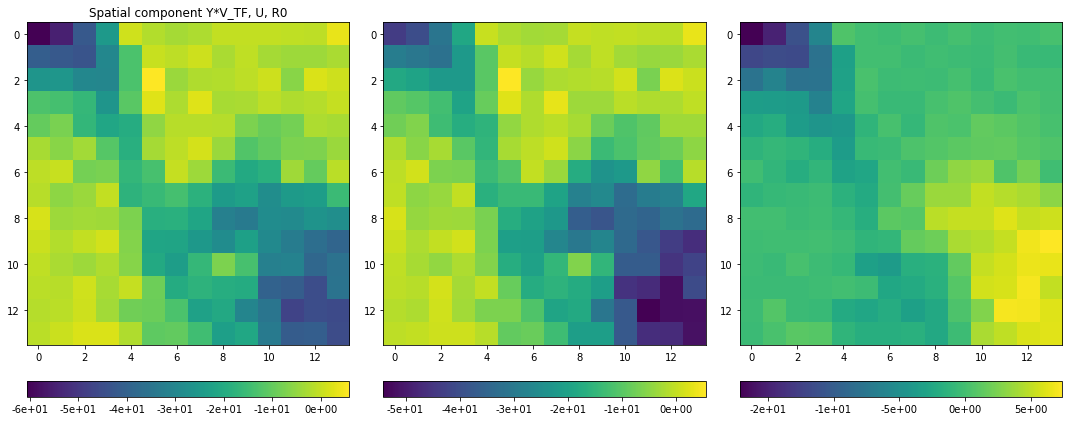

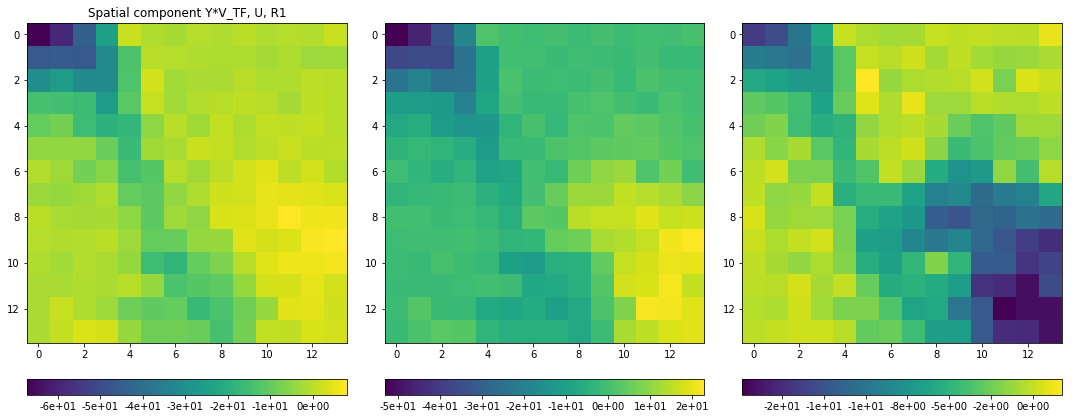

	Iter 8 errors (8767+39+0)=8807
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


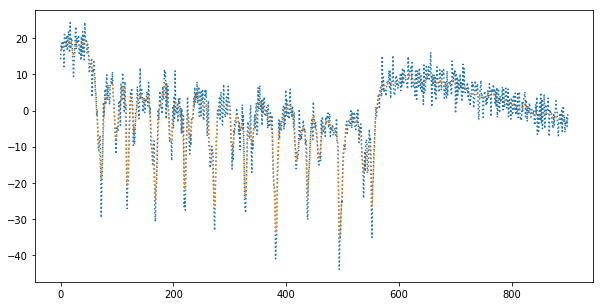

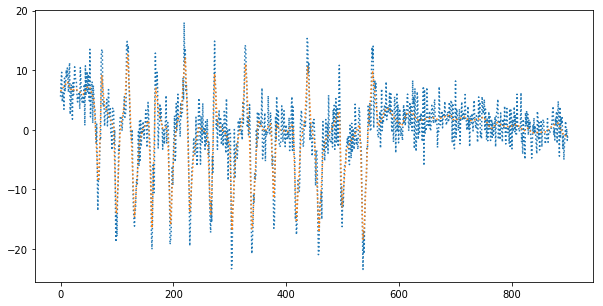

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


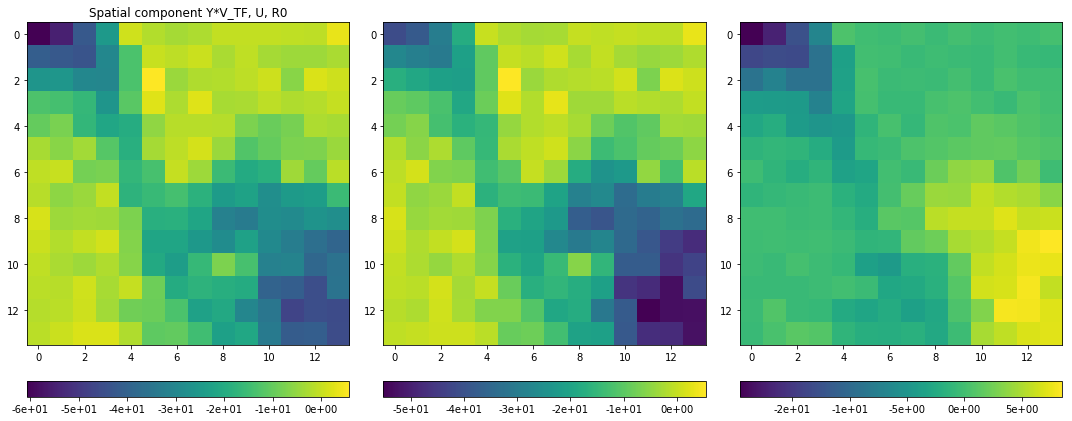

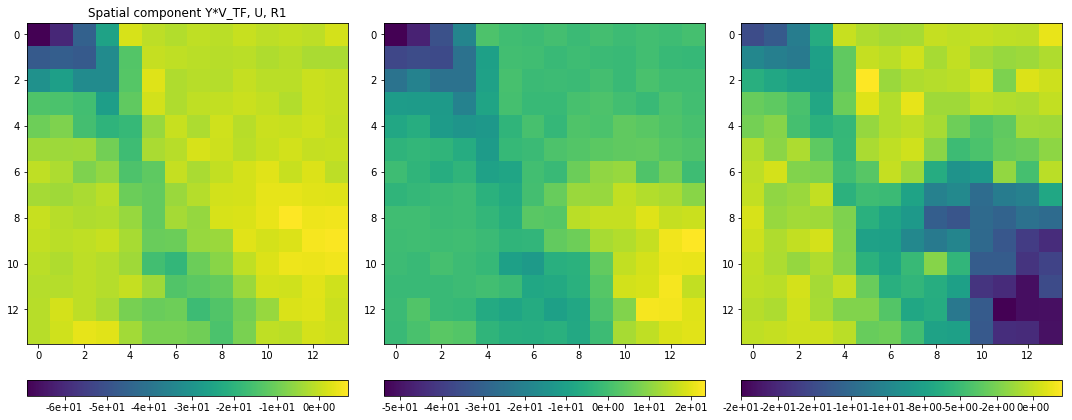

	Iter 9 errors (8729+38+0)=8768
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


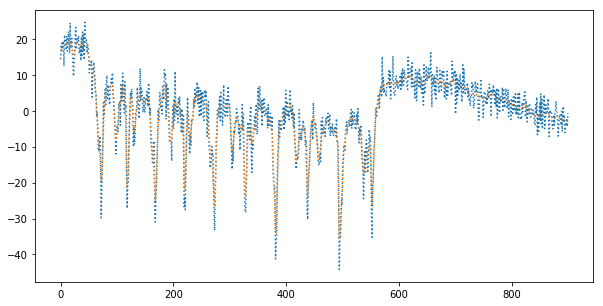

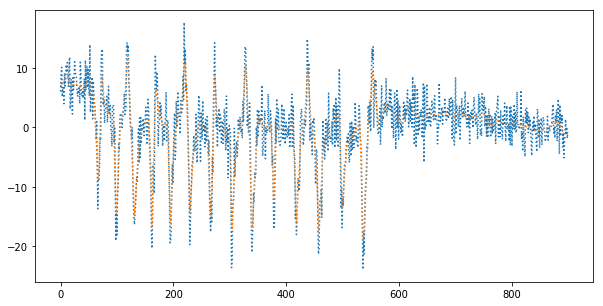

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


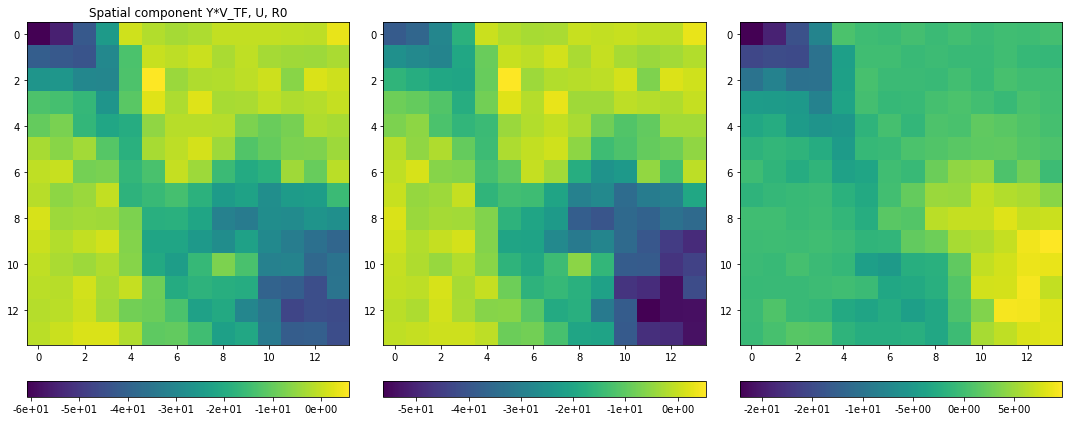

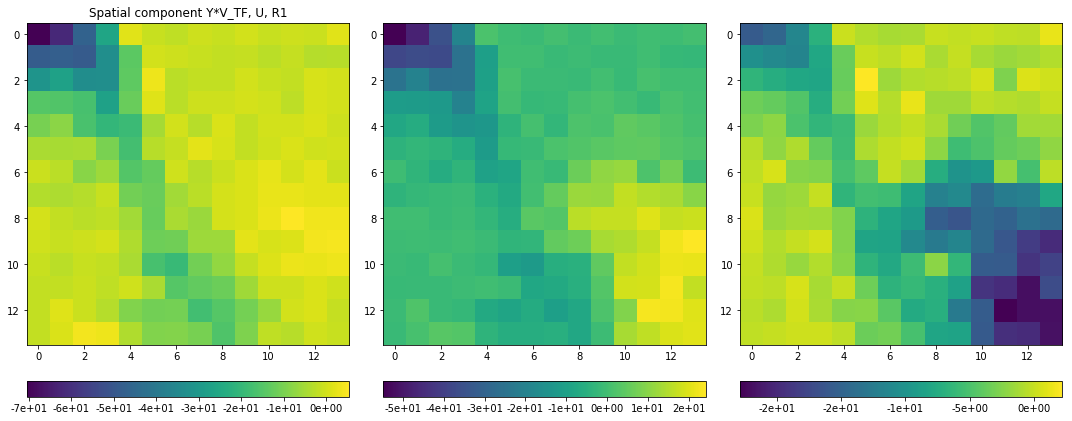

	Iter 10 errors (8693+38+0)=8731
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


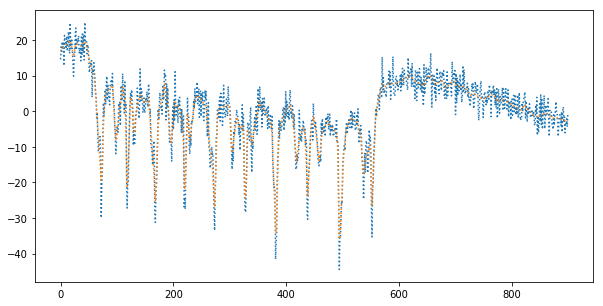

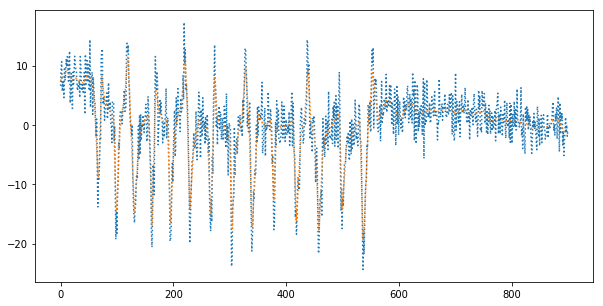

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


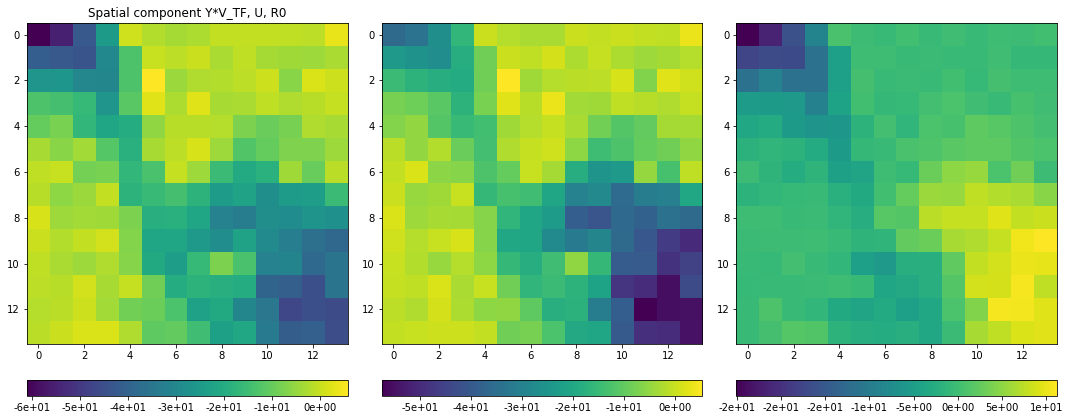

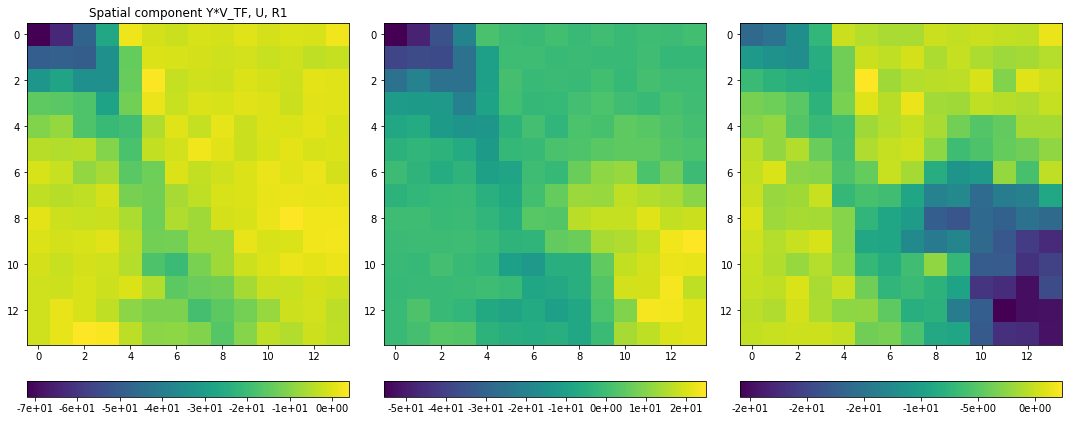

	Iter 11 errors (8657+37+0)=8695
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


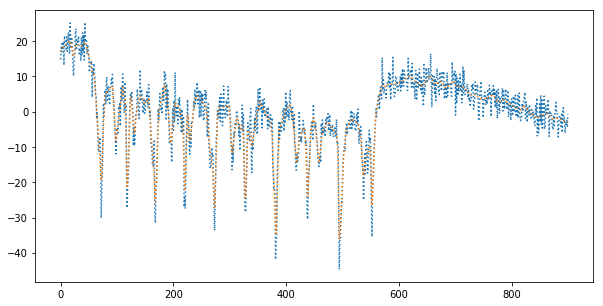

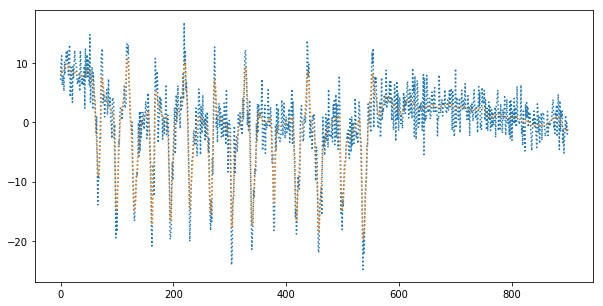

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


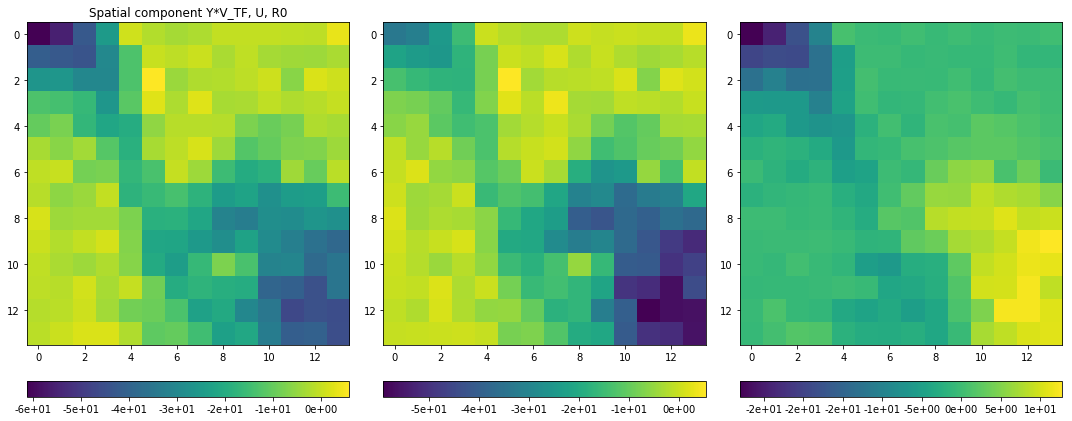

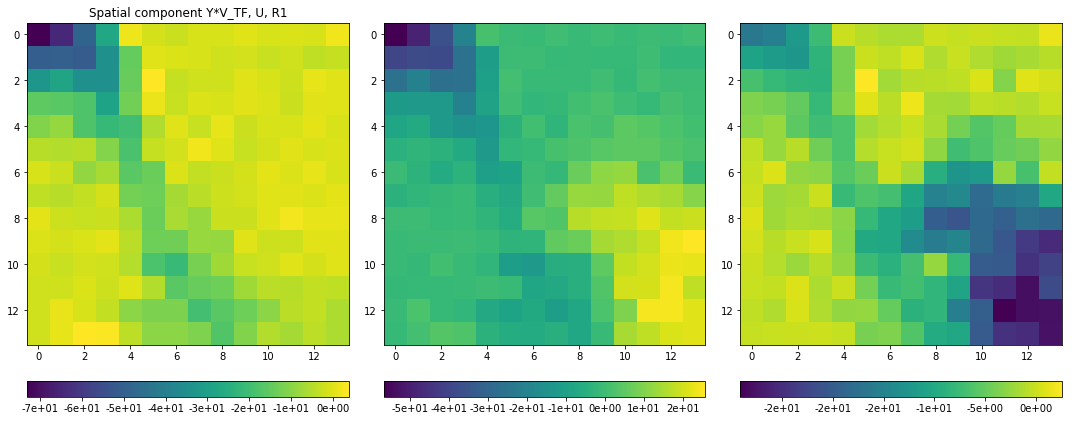

	Iter 12 errors (8625+37+0)=8663
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


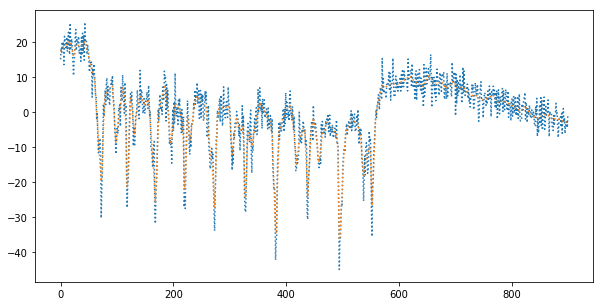

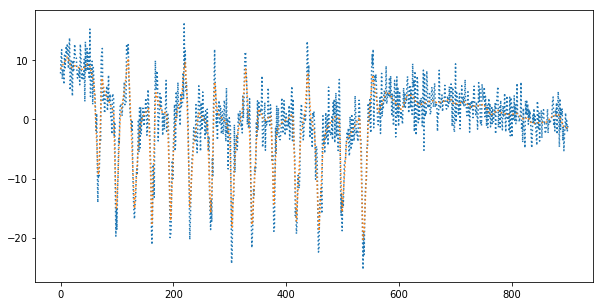

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


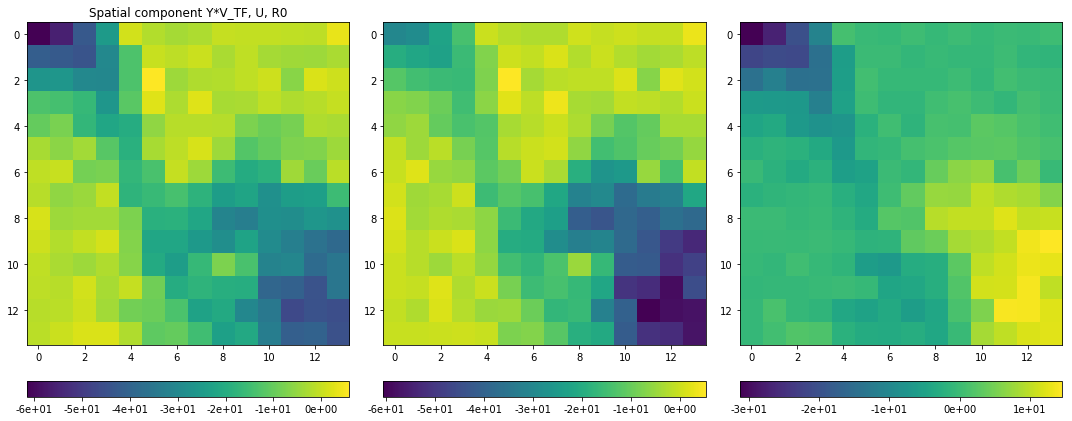

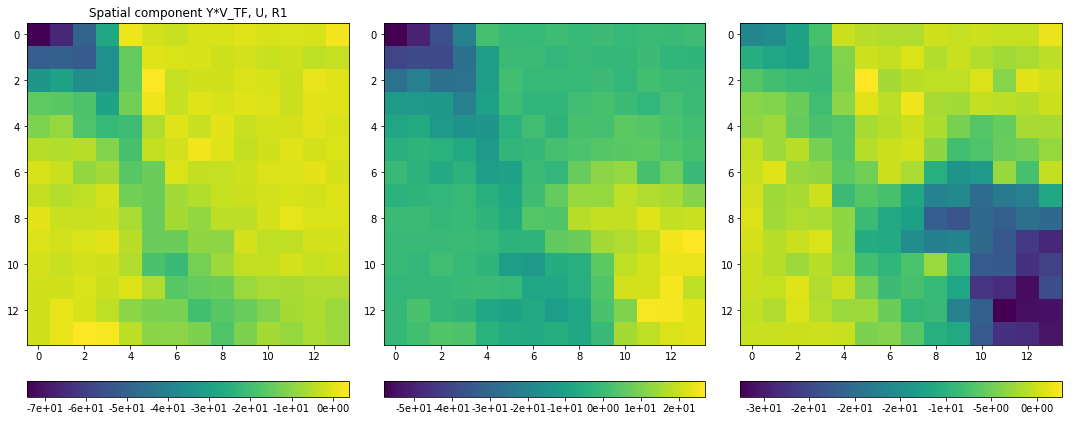

	Iter 13 errors (8602+36+0)=8638
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


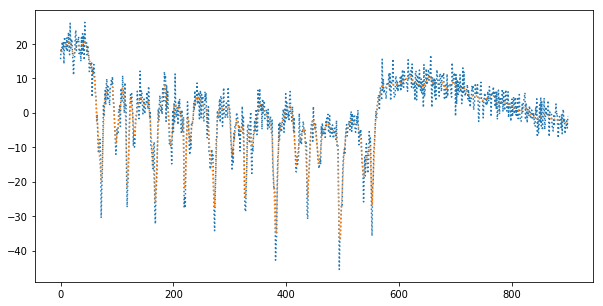

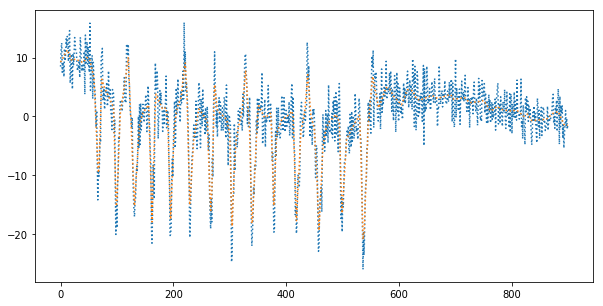

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


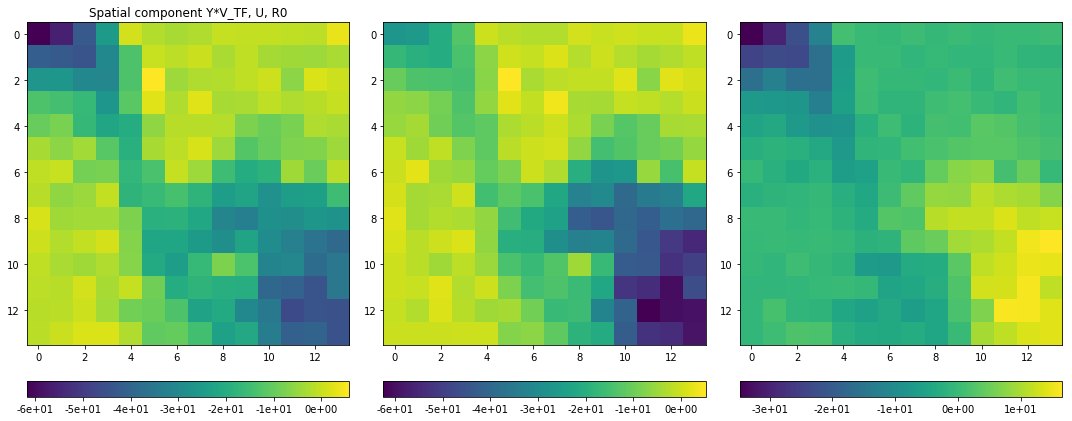

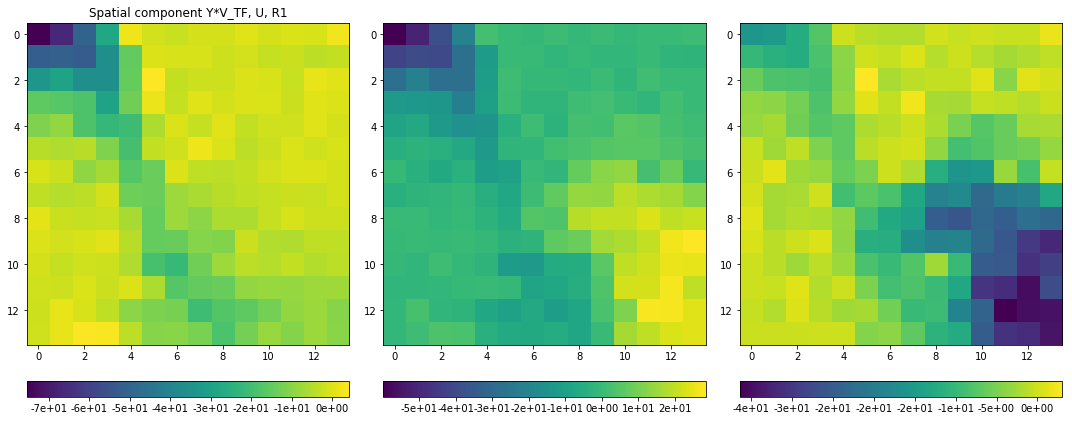

	Iter 14 errors (8581+35+0)=8616
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


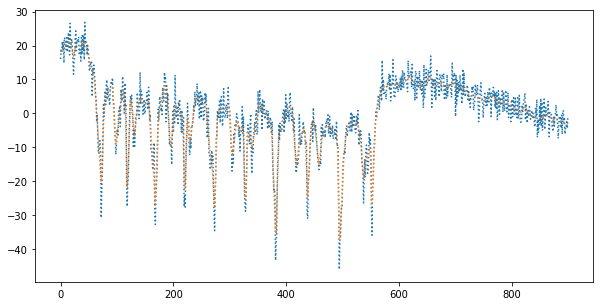

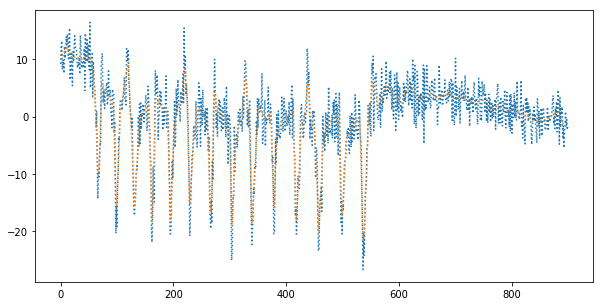

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


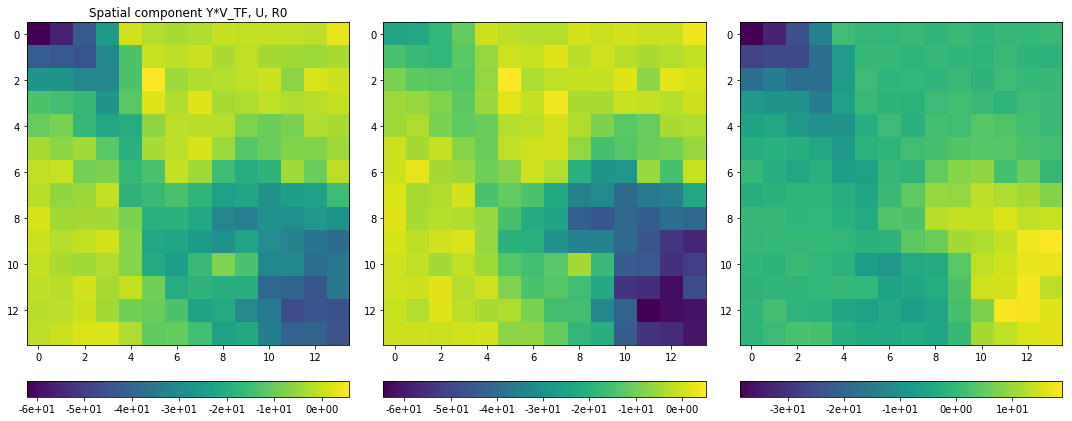

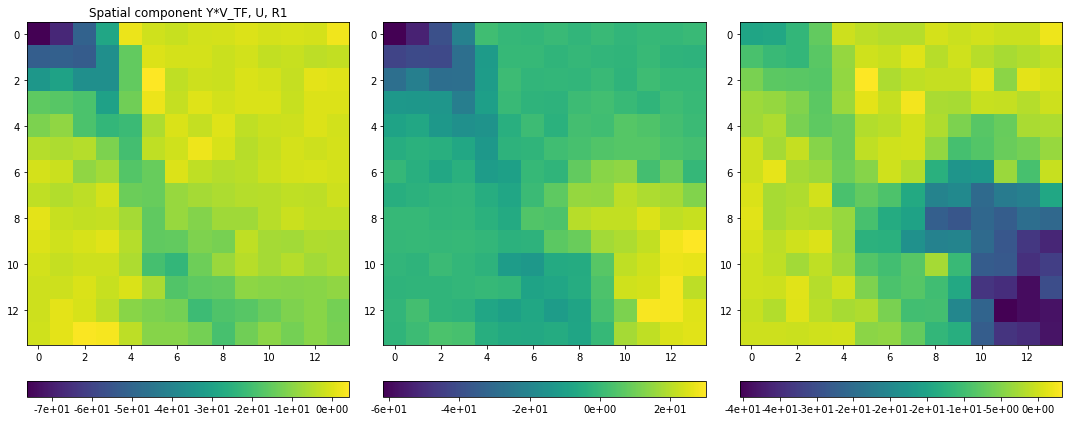

	Iter 15 errors (8565+34+0)=8599
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


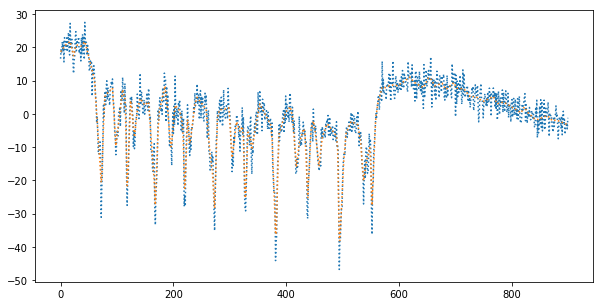

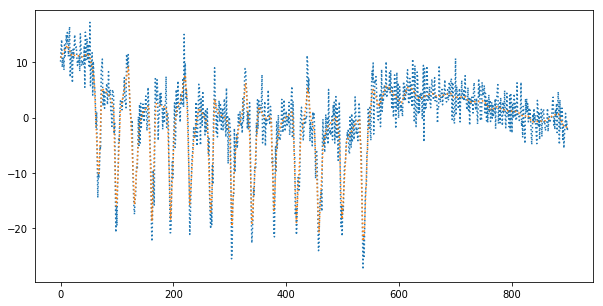

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


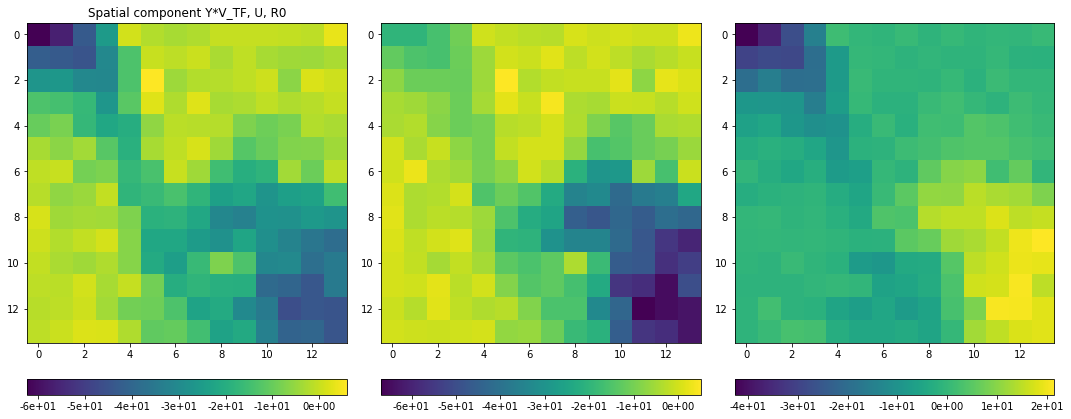

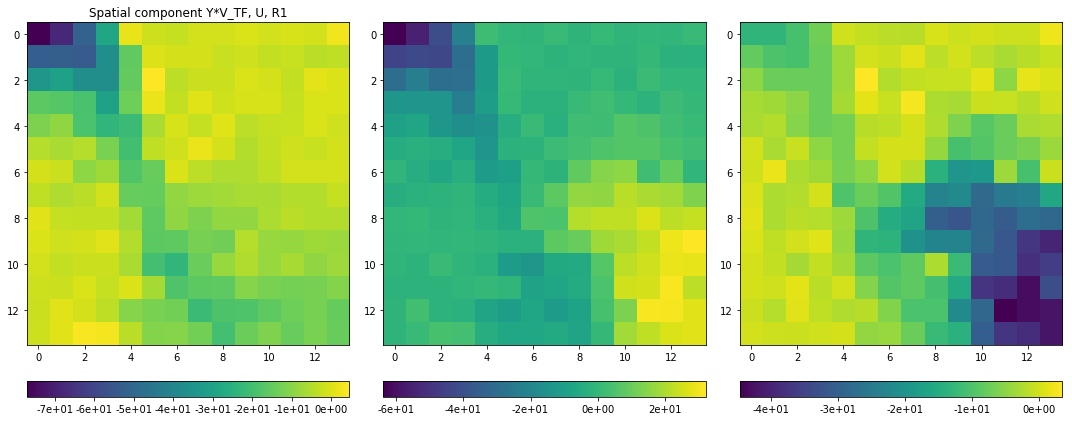

	Iter 16 errors (8561+33+0)=8595
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


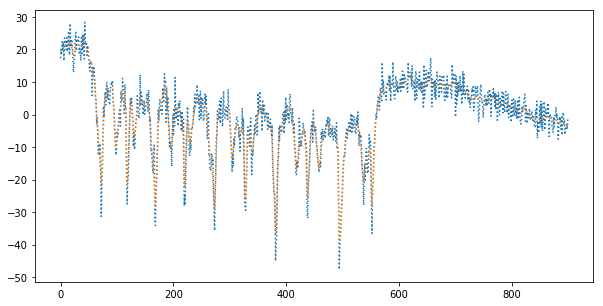

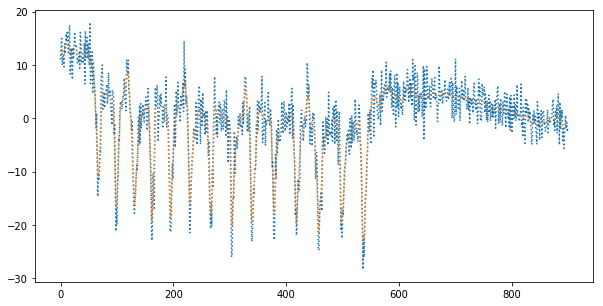

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


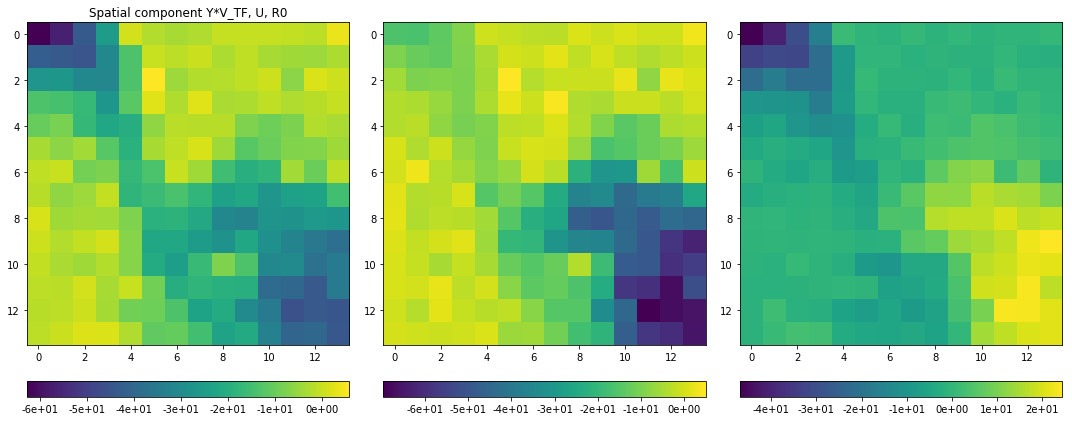

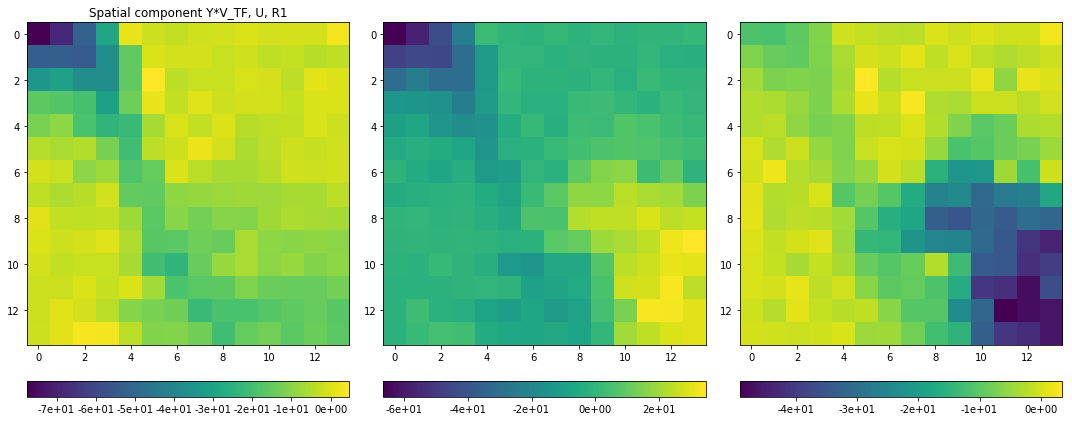

	Iter 17 errors (8580+32+0)=8613
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


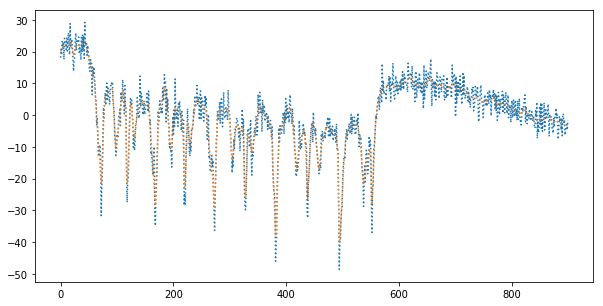

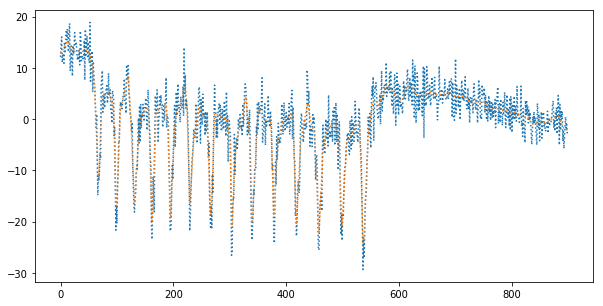

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


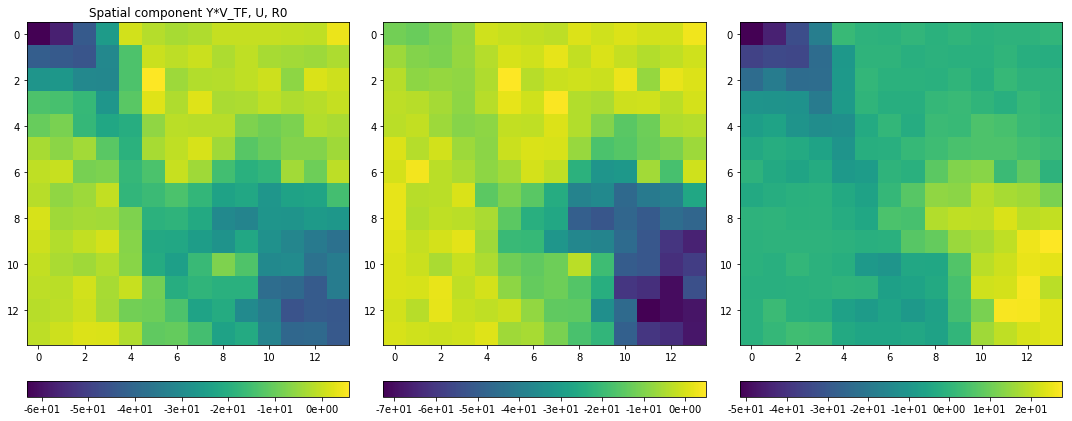

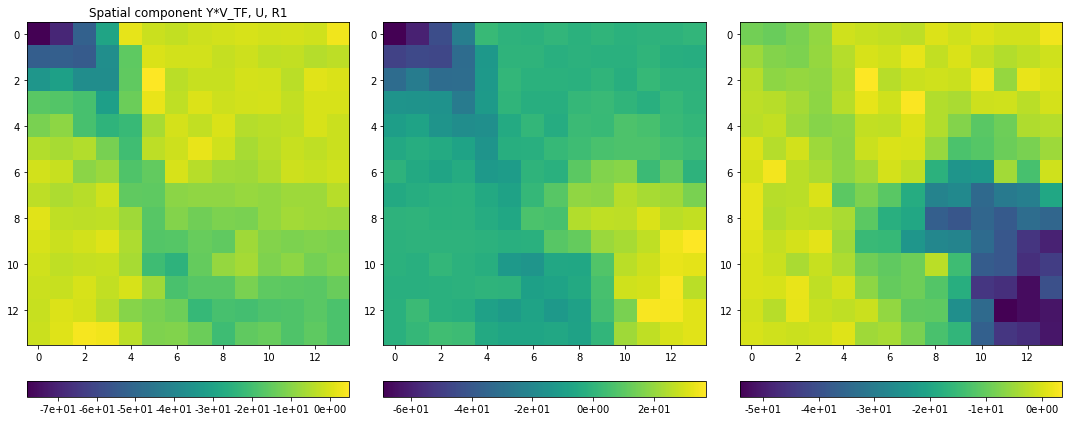

	Iter 18 errors (8616+31+0)=8648
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


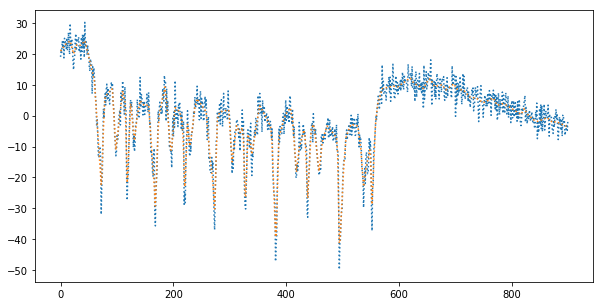

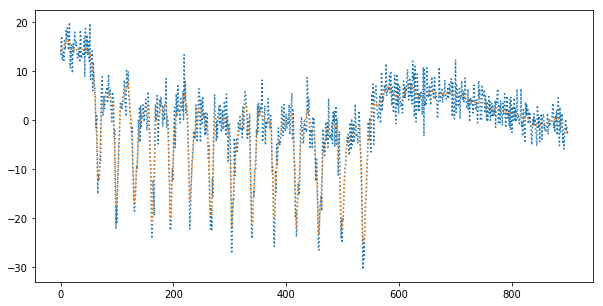

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


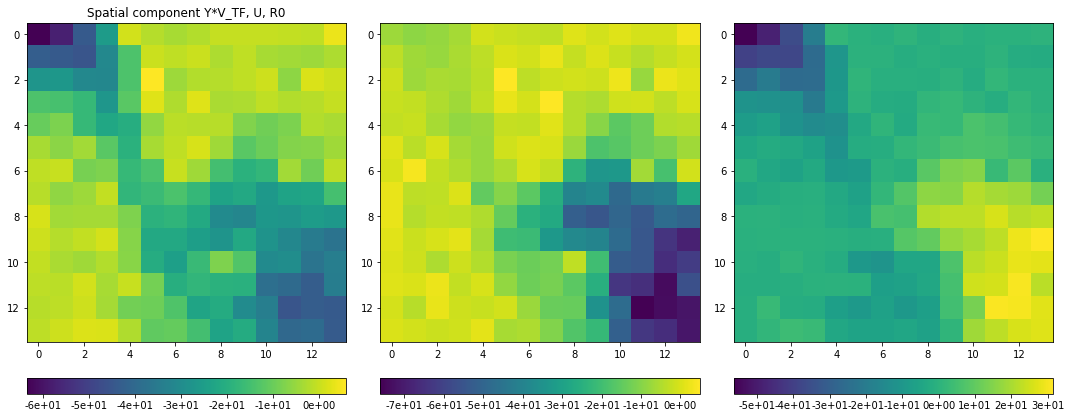

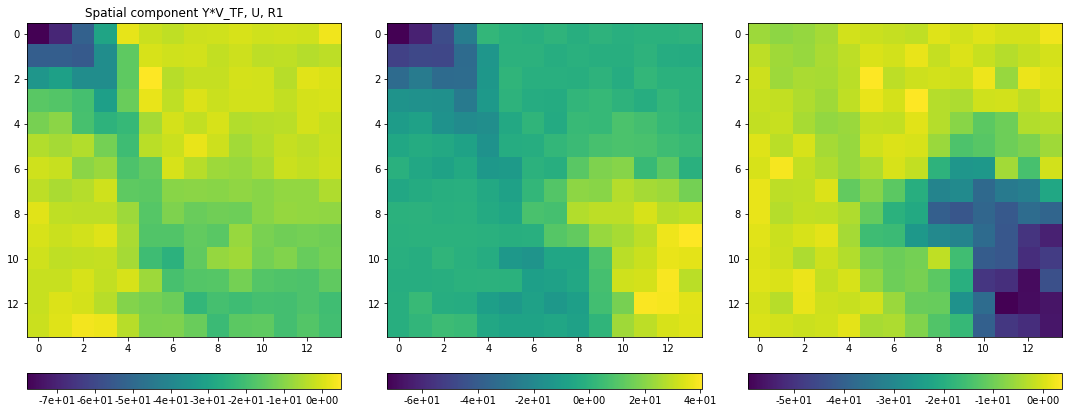

	Iter 19 errors (8666+30+0)=8697


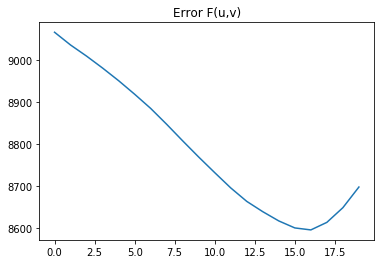

*Running Part (2) of iter 0 with 2 components


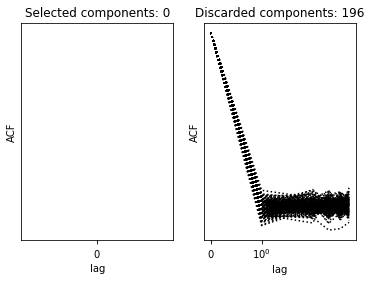

Final number of components 2
Running final update


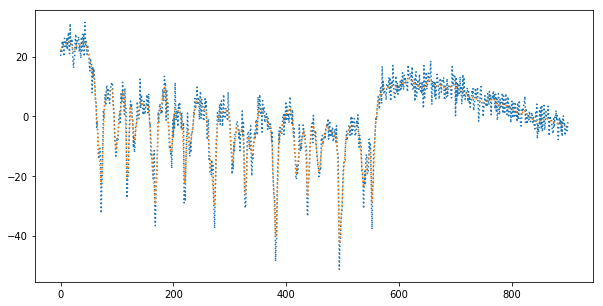

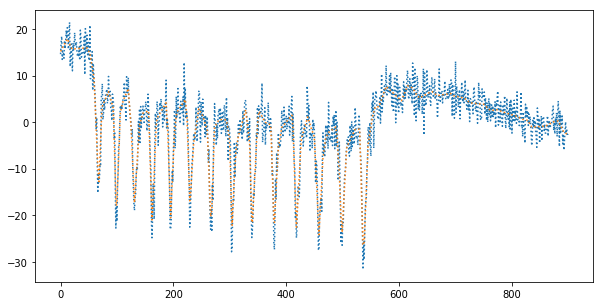

 solve U(j) = argmin_W ||W||_1 st ||Y_j-W'V_TF(j)||_2^2<T


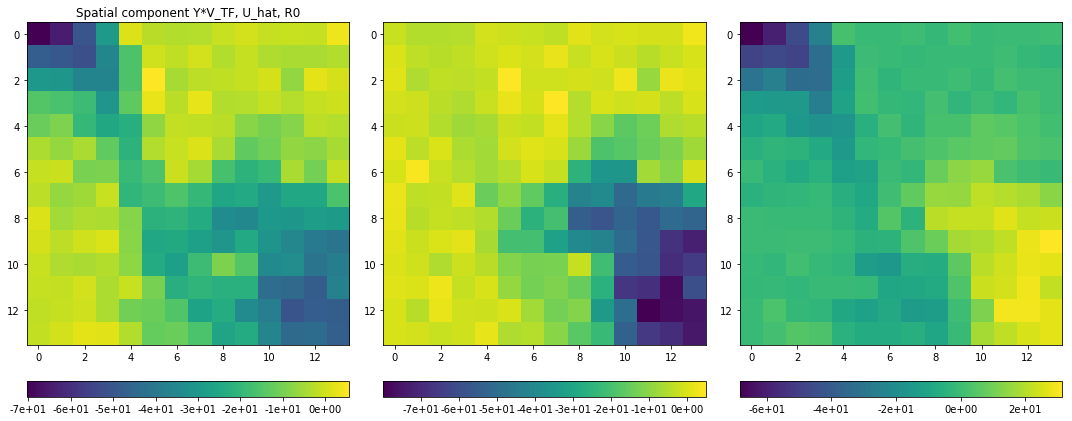

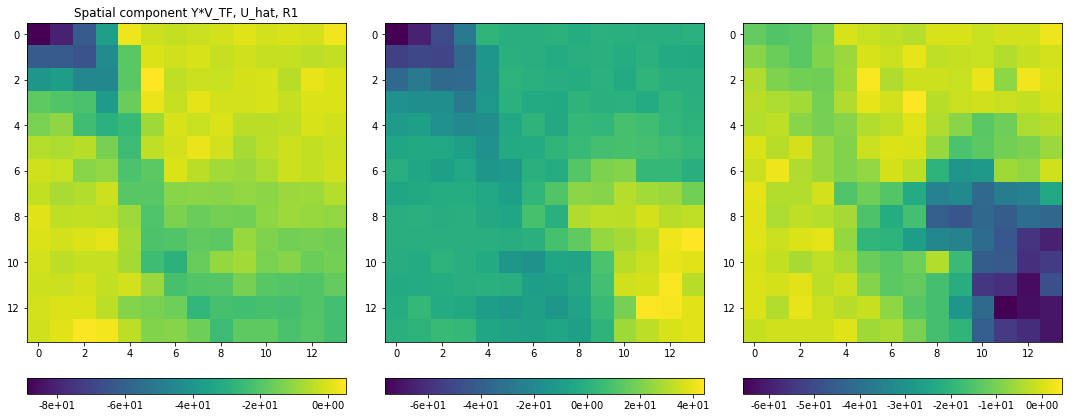

Run for 55


In [16]:
# greedy for a single tile (~ neuron size)
# visualize results for a single tile.
# make sure these look reasonable or if params need to ne updated
patches = pre_svd.split_image_into_blocks(W,k)
start= time.time()
b,_ = pre_svd.compress_dblocks(patches[1],
                                maxlag=maxlag,confidence=confidence,
                                greedy=True,fudge_factor=0.9,
                                mean_th_factor=2,U_update=True,
                              verbose=True,plot_en=True,min_rank=1)
print('Run for %.f'%(time.time()-start))

In [18]:
W_1 = pre_svd.split_image_into_blocks(W,k)

In [19]:
dim_block = np.asarray(list(map(np.shape,W_1)))
cols, rows = dim_block.T[0],dim_block.T[1]

In [23]:
Cn1 = cm.local_correlations(W)

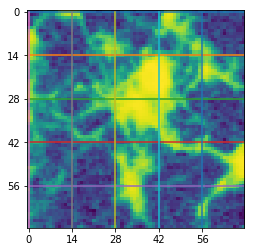

In [25]:
K = int(np.sqrt(len(dim_block)))
row_array = np.insert(rows[::K+1],0,0).cumsum()
col_array = np.insert(cols[::K+1],0,0).cumsum()
x,y = np.meshgrid(row_array[:],col_array[:])

if True:
    for Cn in [Cn1]:
        plt.yticks(col_array)
        plt.xticks(row_array)
        plt.plot(y,x)
        plt.plot(x,y)
        plt.imshow(Cn)
        plt.show()
r_offset = np.diff(row_array)//2
c_offset = np.diff(col_array)//2
row_cut = row_array[:-1]+r_offset
col_cut = col_array[:-1]+c_offset

dims_rs = W.reshape(dims,order='F')[:,row_cut[0]:row_cut[-1],:].shape
dims_cs = W.reshape(dims,order='F')[col_cut[0]:col_cut[-1],:,:].shape
dims_rcs = W.reshape(dims,order='F')[col_cut[0]:col_cut[-1],row_cut[0]:row_cut[-1],:].shape

In [26]:
def extract_off(W,r_offset,c_offset,row_cut,col_cut):
    W_rows = np.array_split(W[:,row_cut[0]:row_cut[-1],:],(row_cut+r_offset)[:-2],axis=1)
    func_c = lambda x: (np.array_split(x,(col_cut+c_offset)[:-1],axis=0))
    W_r_off = list(map(func_c,W_rows))
    
    W_cols = np.array_split(W[col_cut[0]:col_cut[-1],:,:],row_array[1:-1],axis=1)
    func_c = lambda x: (np.array_split(x,(col_cut+c_offset)[:-2],axis=0))
    W_c_off = list(map(func_c,W_cols))
    
    Wrc_col = np.array_split(W[col_cut[0]:col_cut[-1],row_cut[0]:row_cut[-1],:],(row_cut+r_offset)[:-2],axis=1)
    func_c = lambda x: (np.array_split(x,(col_cut+c_offset)[:-2],axis=0))
    W_rc_off = list(map(func_c,Wrc_col))

    W_rs = [y for x in W_r_off for y in x]
    W_cs = [y for x in W_c_off for y in x]
    W_rcs = [y for x in W_rc_off for y in x]
    return W_rs,W_cs,W_rcs

In [28]:
W_rs1,W_cs1,W_rcs1 =  extract_off(W,r_offset,c_offset,row_cut,col_cut)


In [33]:
import multiprocessing

def run_single(Y):
    start=time.time()
    pool = multiprocessing.Pool()
    args=[[patch] for patch in Y]
    # define params in function
    c_outs = pool.starmap(pre_svd.svd_patch,args)
    pool.close()
    pool.join()
    print('Run for %f'%(time.time()-start))
    Yds = [out_[0] for out_ in c_outs]
    vtids = [out_[1] for out_ in c_outs]
    return Yds,vtids

In [43]:
dW_1,rank_dW = run_single(W_1)

Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Forcing one component
M rank 1
Single patch
M rank 1
M rank 1
M rank 1
M rank 1
M rank 1
M rank 1
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 3
M rank 3
M rank 3
M rank 2
M rank 4
M rank 5
M rank 4
M rank 5
Run for 18.581625


In [44]:
dW_rs1,rank_W_rs = run_single(W_rs1)

Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
M rank 1
M rank 1
M rank 1
M rank 1
M rank 1
M rank 1
M rank 1
M rank 1
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 3
M rank 4
M rank 4
M rank 4
M rank 5
Run for 14.963981


In [45]:
dW_cs1,rank_W_cs = run_single(W_cs1)

Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Forcing one component
M rank 1
M rank 1
M rank 1
M rank 1
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 2
M rank 3
M rank 3
M rank 3
M rank 3
M rank 3
M rank 4
M rank 4
M rank 7
M rank 6
Run for 18.202734


In [46]:
dW_rcs1,rank_W_rcs = run_single(W_rcs1)

Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
Single patch
M rank 1
M rank 1
M rank 1
M rank 1
M rank 2
M rank 2
M rank 2
M rank 2
M rank 3
M rank 3
M rank 3
M rank 3
M rank 4
M rank 5
M rank 6
M rank 6
Run for 16.786607


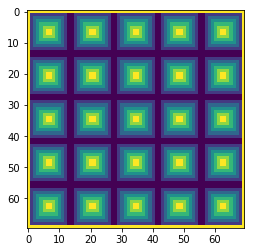

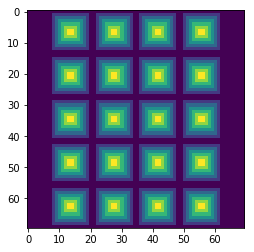

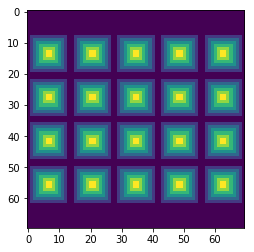

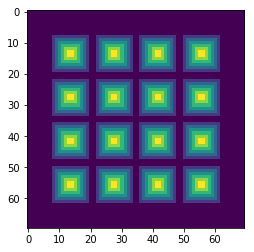

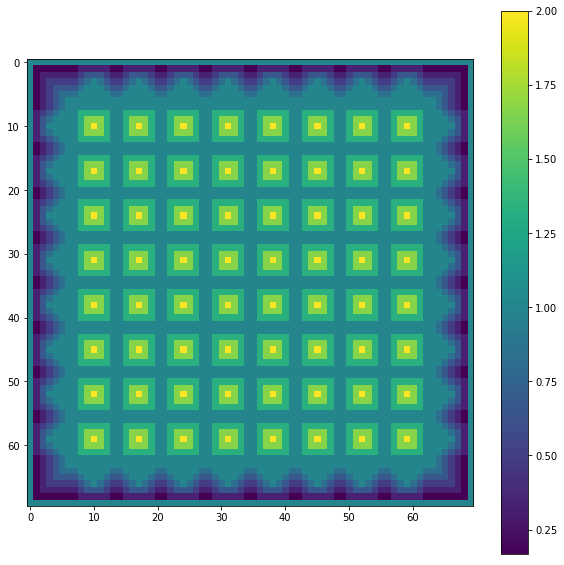

In [47]:
W1_four = pre_svd.combine_4xd(dims,row_cut,col_cut,dW_1,dW_rs1,dW_cs1,dW_rcs1)

In [48]:
# Visualize local correlation
def show_img(ax, img,vmin=None,vmax=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    im = ax.imshow(img,vmin=vmin,vmax=vmax,cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    if np.abs(img.min())< 1:
        format_tile ='%.2f'
    else:
        format_tile ='%5d'
    plt.colorbar(im, cax=cax, orientation='horizontal',
                 spacing='uniform',format=format_tile)#'%.2f') # %3d for 2p

In [52]:
dW_1r = pre_svd.combine_blocks(dims,dW_1,list_order='C')

min -19.519492718094245,  max 54.187324587704936
min -19.386034988891165,  max 53.74317016331333
min -5.759316678406331,  max 5.450609844943201


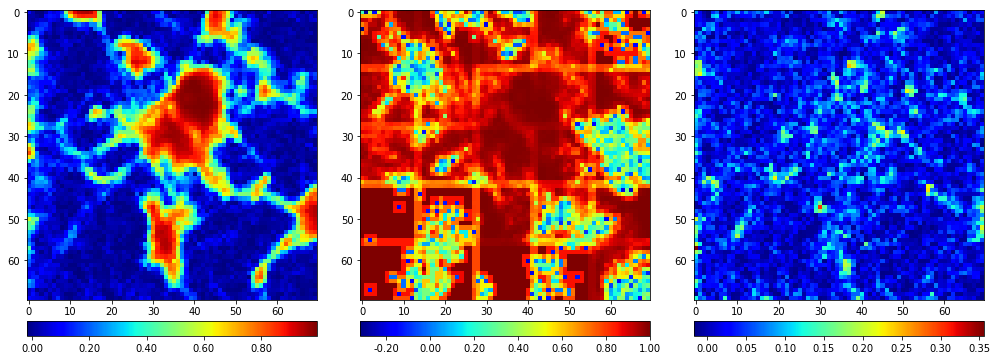

In [56]:
cn_see = [W,dW_1r,W-dW_1r]
fig, axarr = plt.subplots(1,3,figsize=(14,5),sharex=True)
for ii, array in enumerate(cn_see):
    if not type(array)==cm.base.movies.movie:
        Cn_pre = cm.movie(array.transpose([2,0,1]))
    else:
        Cn_pre = array.transpose([2,0,1])
    #Cn = Cn_pre.local_correlations(swap_dim=False)
    Cn, _ = cm.summary_images.correlation_pnr(array, gSig=None, center_psf=False) # 10 no ds
    print ('min {},  max {}'.format(array.min(),array.max()))
    # VARIANCE
    #Cn = array.var(2)/array.shape[2]
    # PNR
    #_, Cn = cm.summary_images.correlation_pnr(array, gSig=None, center_psf=False)
    #fig = plt.figure(figsize=(10,5))
    #ax = plt.axes()
    #ax.axis('off')
    show_img(axarr[ii], Cn)#,vmin=Cn.min(),vmax=Cn.max())
    ##fig = plt.gcf()
    ##fig.set_size_inches(40, 8)
plt.tight_layout()
plt.show()

In [57]:
M1 = cm.movie(np.asarray(W).transpose([2,0,1]))
M2 = cm.movie(np.asarray(Yd1).transpose([2,0,1]))
M3 = cm.movie(np.asarray(W1_four).transpose([2,0,1]))

M4  = M1 - M2
M5  = M1 - M3

MZ = np.zeros(M1.shape)
if True:
    M1 = M1-M1.min(0,keepdims=True)
    M2 = M2-M2.min(0,keepdims=True)
    M3 = M3-M3.min(0,keepdims=True)
    M4 = M4-M4.min(0,keepdims=True)
    M5 = M5-M5.min(0,keepdims=True)

cm.concatenate([
    cm.concatenate([M1,M2,M3],axis=2),
    cm.concatenate([MZ,M4,M5],axis=2)
    ],axis=1).play(gain=1,magnification=4)

In [ ]:
# not parallel, single greedy denoiser
if False:
    Yd,_ = pre_svd.svd_patch(W,k=k,maxlag=maxlag,confidence=confidence,
                             greedy=True,fudge_factor=0.9,mean_th_factor=2,min_rank=1,
                             U_update=True,plot_en=False)

In [59]:
def redo_(W_,dims,noise_level,mean_px):
    W = W_.reshape((np.prod(dims[:2]),dims[2]),order='F').copy()
    W= W*noise_level[:,np.newaxis]
    W+= mean_px
    W = W.reshape(dims,order='F')
    return W

In [61]:
images_rd_= images_r.reshape(dims,order='F')
# one denoiser: for one use Yd
Yd1_ = redo_(Yd1,dims,noise_level,mean_px) #vanilla
Yd_ = redo_(W1_four,dims,noise_level,mean_px) #greedy

In [64]:
# [W, Yd1, W1_four] or [images_rd_,Yd1_,Yd_]
M1 = cm.movie(np.asarray(images_rd_).transpose([2,0,1])) 
M2 = cm.movie(np.asarray(Yd1_).transpose([2,0,1]))
M3 = cm.movie(np.asarray(Yd_).transpose([2,0,1]))

M4  = M1 - M2
M5  = M1 - M3

MZ = np.zeros(M1.shape)
if True:
    M1 = M1-M1.min(0,keepdims=True)
    M2 = M2-M2.min(0,keepdims=True)
    M3 = M3-M3.min(0,keepdims=True)
    M4 = M4-M4.min(0,keepdims=True)
    M5 = M5-M5.min(0,keepdims=True)

cm.concatenate([
    cm.concatenate([M1,M2,M3],axis=2),
    cm.concatenate([MZ,M4,M5],axis=2)
    ],axis=1).play(gain=1,magnification=4)